In [1]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import pandas as pd
from matplotlib import pyplot as plt
from autograd.scipy.stats import multivariate_normal, norm
from matplotlib.gridspec import GridSpec
import numpy
from matplotlib import cm
from tqdm import tqdm
from numba import jit
from scipy.integrate import dblquad

/home/elisionducoeur/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: covariance is not positive-semidefinite.
  return f_raw(*args, **kwargs)


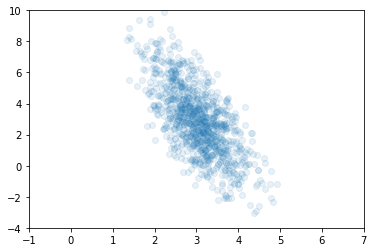

In [2]:
# Target density
n_samples = 1000
xs = 2*np.pi*np.random.random(n_samples) - np.pi
#target_samples = np.array(list(zip(xs, np.sin(xs)+0.1*np.random.randn(n_samples))))

target_samples = np.random.multivariate_normal([3,3], [[1,-5],[0,1]], n_samples)
fig, ax = plt.subplots()
ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.1)
ax.set(xlim=(-1,7), ylim=(-4,10))
plt.show()

In [3]:
def u1(z, N=1):
    # z is generated data
    # N is normalizing constant
    exp_factor = 1/2*((np.linalg.norm(z, axis=2) - 2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,:,0] - 2)/0.6)**2) + np.exp(-1/2*((z[:,:,0] + 2)/0.6)**2))
    return N * np.exp(-exp_factor)

def u1_int(x, y):
    exp_factor = 1/2*((np.linalg.norm([x,y])-2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((x-2)/0.6)**2) + np.exp(-1/2*((x+2)/0.6)**2))
    return np.exp(-exp_factor)

def u1_target(z, N=1):
    exp_factor = 1/2*((np.linalg.norm(z, axis=1)-2)/0.4)**2 - \
                 np.log(np.exp(-1/2*((z[:,0]-2)/0.6)**2) + np.exp(-1/2*((z[:,0]+2)/0.6)**2))
    return N*np.exp(-exp_factor)

def u2(z, N=1):
    exp_factor = 1/2*((z[:,:,1] - np.sin(2*np.pi*z[:,:,0]/0.4))/0.4)**2
    return np.exp(-exp_factor)

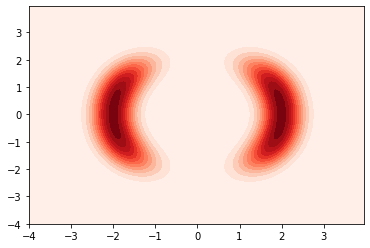

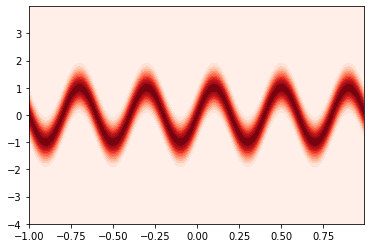

In [4]:
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))
fig, ax = plt.subplots()
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15)
plt.show()

X, Y = numpy.mgrid[-1:1:0.01, -4:4:0.01]
dat = np.dstack((X, Y))
fig, ax = plt.subplots()
ax.contourf(X, Y, u2(dat), cmap='Reds', levels=15)
plt.show()

result = dblquad(u1_int, -4, 4, lambda x: -4., lambda x: 4.)[0]
u1_normalizing_factor = 1/result

In [5]:
def flow(z, lbda, func): # Planar transformation
    return z + func((z @ lbda[2:4].reshape(-1, 1))+lbda[-1]) @ lbda[:2].reshape(1, -1)

# breaks if using func instead of np.tanh
def psi(z, lbda, func): # Psi used in ELBO
    return np.tanh((z @ lbda[2:4].reshape(-1, 1))+lbda[-1]) @ lbda[2:4].reshape(1, -1)

def flow_samples(z, flow_func, lbdas): # Does flow for multiple transformations
    for k in range(len(flow_func)):
        z = flow_func[k](z, lbdas[k])
    return np.array(z)

In [6]:
def free_energy(z, lbda, q, p, flows, x, beta=0.1): # ELBO
    # z is samples of shape (S, K)
    # q is distribution z was drawn from
    # p is target distribution (observations?)
    # flows is list of flow functions
    
    # TODO: keep explicit lambda dependence in p(x, z_k) -> will hopefully fix things?
    # But its a joint and they're independent, so not sure how it depends on target
    # Basically just need original and k-th transformation
    
    #q_exp = np.sum(q(z[0]))/len(z[0])
    q_exp = 0
    joint_exp = beta*sum(p(flow_samples(z, flows, lbda)))
    flow_exp = 0
    for k in range(len(lbda)):
        flow_exp += np.sum(np.log(np.abs(1 + np.dot(flows[k](z, lbda[k]), lbda[0][:2]))))
    #print("FREE ENERGY: {}".format(flow_exp/len(z) + joint_exp))
    return flow_exp + joint_exp

# Fitting the first (potentially easiest) potential from the paper

[[1. 0. 4. 5. 0.]
 [1. 0. 4. 5. 0.]]


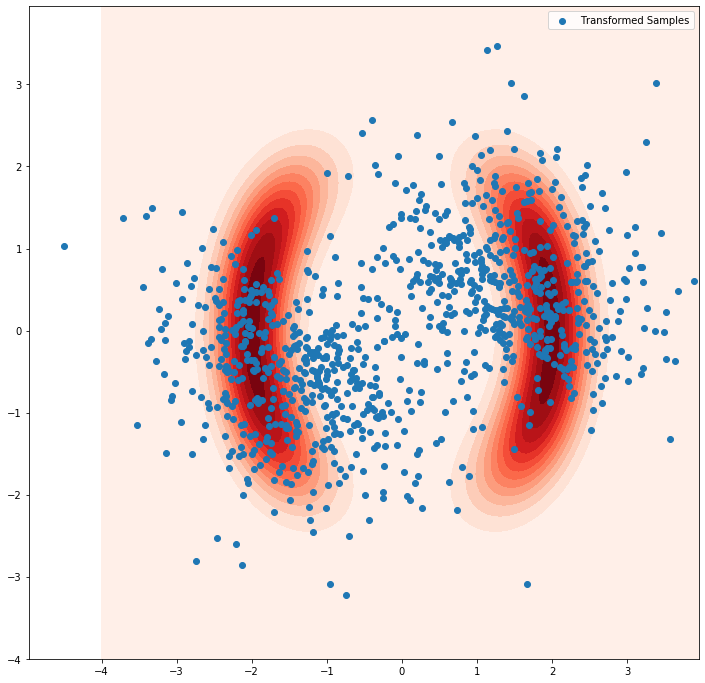

In [7]:
# Samples from initial distribution
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

# Setting up flow parameters - splits data vertically, is a good example
lbda = [np.array([-10., 10., 0., 150., 0.1])]


# Set up parameters for learning flow
flows = 2
lbda = np.array([np.ones(5)*2.]*flows)
lbda = np.array([np.array([1., 0., 4., 5., 0.])]*flows)
print(lbda)
#raise
func = lambda x: np.tanh(x)  # Function for transformation
flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows

# Flow samples
samples = flow(samples, lbda[0], func)

# Current and target distributions
p = lambda x: u1_target(x, u1_normalizing_factor)
q = lambda z: np.log(multivariate_normal.pdf(z, [0,0], np.eye(2)))

# Set up Free Energy function to minimize
en = free_energy(samples, lbda, q, p, flow_func, target_samples)
en_func = lambda lmda: free_energy(samples, lmda, q, p, flow_func, target_samples)
grad_en_func = grad(en_func)

# Set up grid to plot
X, Y = numpy.mgrid[-4:4:0.05, -4:4:0.05]
dat = np.dstack((X, Y))

# Plot everything
fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(samples[:,0], samples[:,1], label="Transformed Samples")

ax.legend(loc='best')
plt.show()

ORIGINAL LAMDA:
[[1. 0. 4. 5. 0.]
 [1. 0. 4. 5. 0.]]



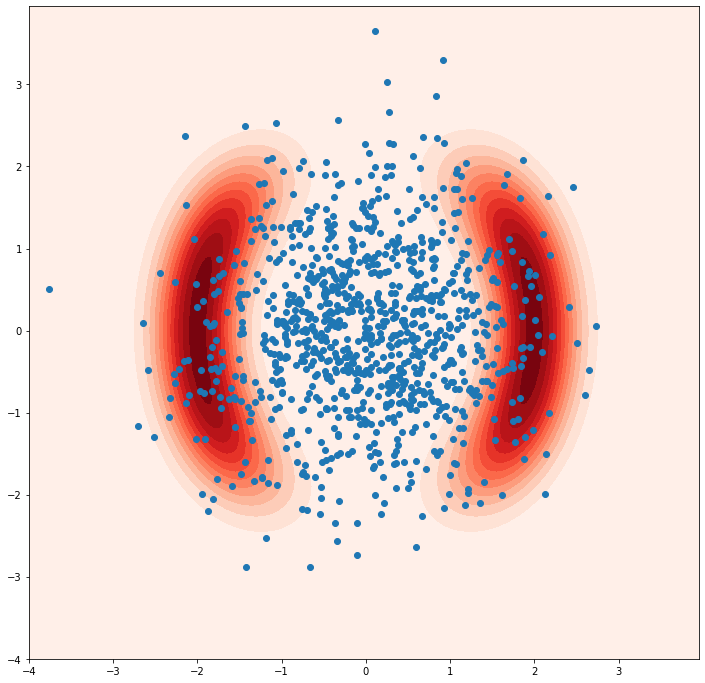

  0%|          | 0/200 [00:00<?, ?it/s]

[[2135.43411851 2669.29264814   14.20135677  232.79450931  -25.63291207]
 [   0.            0.           11.88938561  234.6440168   -20.91612034]]


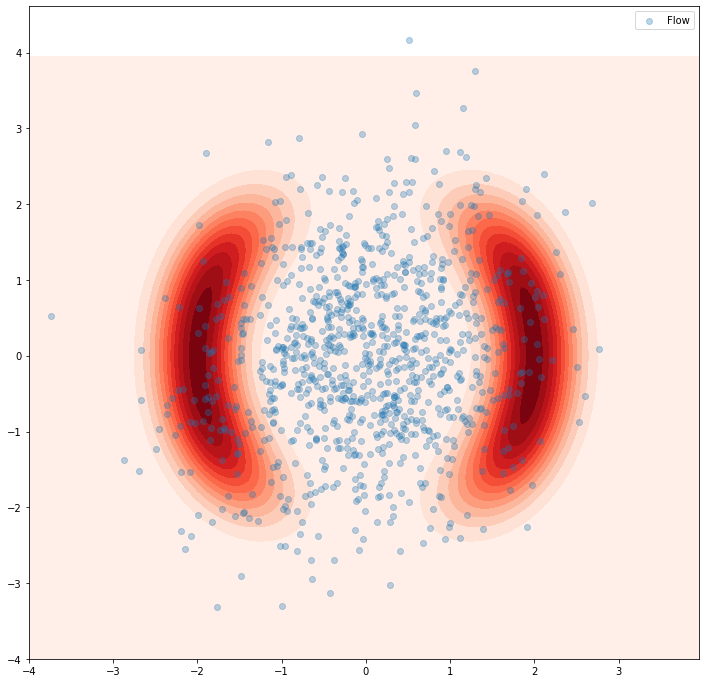

  2%|▏         | 3/200 [00:00<00:45,  4.33it/s]

[[-1.56645227e-01 -2.08349349e+00 -7.24080746e+00 -9.81078891e+00
   1.54581309e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.29451310e+01 -1.72555656e+01
   1.66579734e+02]]
[[-0.36320862 -0.77083978  0.26433457  0.12493241  0.01288651]
 [ 0.          0.          0.32900397  0.15496363 -0.03993084]]
[[-0.04295837  0.01286023 -0.0067662   0.01480332  0.00097525]
 [ 0.          0.          0.00423352 -0.00945332 -0.05681745]]


  3%|▎         | 6/200 [00:00<00:31,  6.08it/s]

[[ 0.04384127  0.00550003  0.0040081   0.02120839  0.04413818]
 [ 0.          0.         -0.0077894  -0.03964968  0.00214761]]
[[ 0.03506002 -0.01327216 -0.00232444  0.03608477 -0.01091777]
 [ 0.          0.         -0.00023987  0.00373568 -0.00169251]]
[[ 0.02253856  0.0069237   0.01082971 -0.00319847  0.00380242]
 [ 0.          0.         -0.02807304  0.00772559 -0.0893252 ]]


  5%|▌         | 10/200 [00:01<00:22,  8.37it/s]

[[ 0.02190323 -0.05764021 -0.04894508 -0.00123898 -0.00213543]
 [ 0.          0.          0.03726473  0.00110014  0.0218068 ]]
[[ 0.03179494  0.02292     0.00070458 -0.00284562 -0.01616535]
 [ 0.          0.          0.00674038 -0.02725428 -0.00813079]]
[[ 6.96545897e-03  3.47818731e-02 -4.73026976e-04 -5.35398295e-04
  -2.11469055e-05]
 [ 0.00000000e+00  0.00000000e+00  4.82224716e-04  5.78095671e-04
   3.29455155e-03]]
[[-1.73444762e-02 -3.29595481e-05  4.12234200e-02  3.03127042e-02
   2.05295047e-02]
 [ 0.00000000e+00  0.00000000e+00  6.81821489e-02  4.95882535e-02
  -2.60991261e-02]]


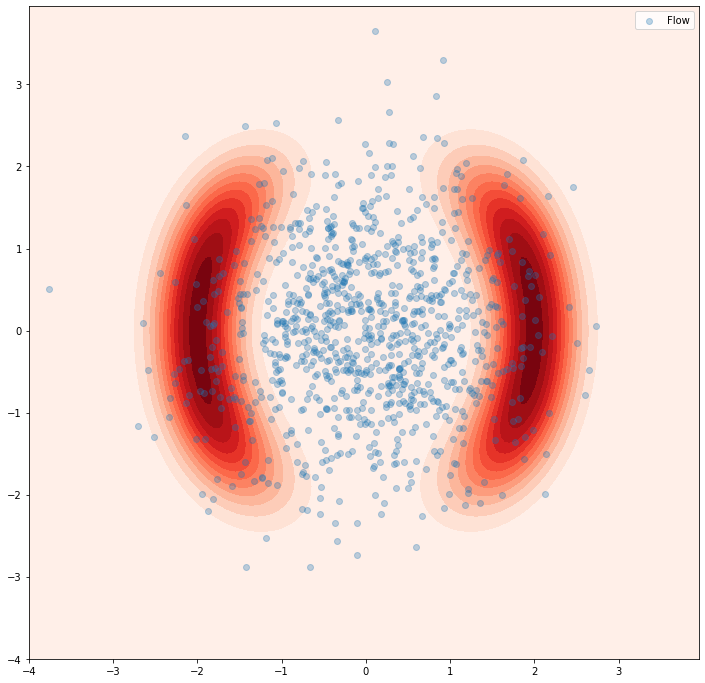

  6%|▋         | 13/200 [00:01<00:24,  7.57it/s]

[[ 0.03336679  0.00747046 -0.01427124 -0.00408812 -0.00954797]
 [ 0.          0.         -0.01008649 -0.00295884 -0.01518992]]
[[ 0.03179089 -0.04154779  0.00028604 -0.02957174 -0.03126516]
 [ 0.          0.         -0.00019795  0.03923973 -0.05285887]]
[[-0.02260582  0.00352856 -0.00973005 -0.00826785 -0.02767604]
 [ 0.          0.          0.03757322  0.03070866 -0.02386731]]


  8%|▊         | 15/200 [00:01<00:21,  8.69it/s]

[[-0.02680406 -0.00884756 -0.02730414  0.04767082  0.03832192]
 [ 0.          0.          0.04452252 -0.07739195  0.01680618]]
[[ 0.01276159  0.02008681 -0.02081813  0.02432831 -0.01191552]
 [ 0.          0.          0.0088803  -0.01062896 -0.04117915]]


 10%|▉         | 19/200 [00:02<00:18,  9.64it/s]

[[-0.0225677  -0.01678362 -0.10612069  0.08811549  0.02037703]
 [ 0.          0.         -0.02941901  0.02410324 -0.04746672]]
[[-0.018056    0.01336058 -0.00808846 -0.02691242 -0.00388409]
 [ 0.          0.          0.00151813  0.00553031  0.03440753]]
[[-1.21953131e-02 -8.52613757e-03 -3.64981073e-03  2.22413593e-03
   1.48663511e-02]
 [ 0.00000000e+00  0.00000000e+00  3.37679837e-05 -2.04819557e-04
  -2.81667670e-02]]
[[-0.22749208  0.02888102  0.00190074 -0.00160512 -0.02054131]
 [ 0.          0.         -0.05498601  0.04316175  0.06343309]]
[[ 0.04960927 -0.00906912 -0.01891932  0.04189462 -0.02813131]
 [ 0.          0.         -0.00011703  0.00037752  0.03511159]]


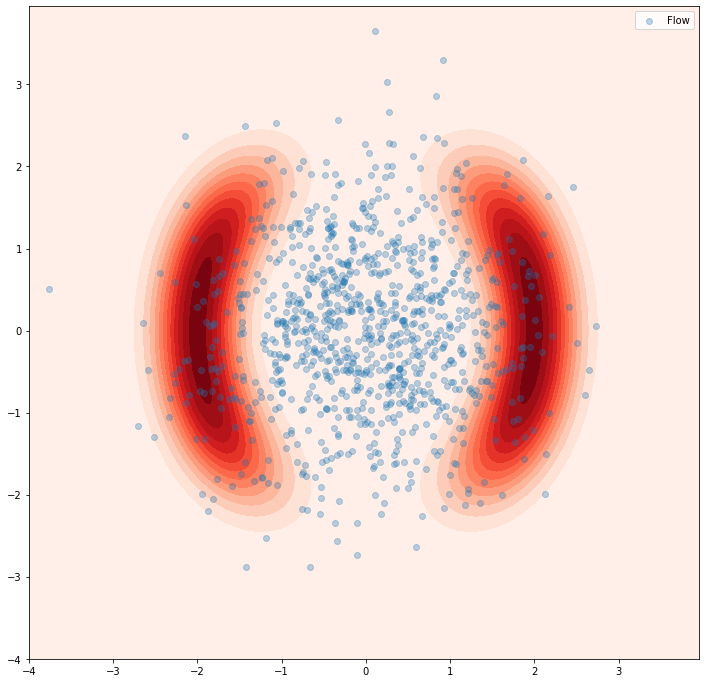

 12%|█▏        | 23/200 [00:02<00:20,  8.72it/s]

[[-0.01414902  0.02677278  0.01215662  0.01017355 -0.02513986]
 [ 0.          0.          0.01598944  0.0139505   0.02781767]]
[[ 0.01215236  0.0164479  -0.00512555  0.00421768 -0.00480938]
 [ 0.          0.          0.00296918 -0.00252109 -0.01004797]]
[[ 0.04861409 -0.02823538 -0.08698478 -0.03148945 -0.04839656]
 [ 0.          0.          0.01422399  0.00466684 -0.04932707]]


 14%|█▎        | 27/200 [00:02<00:16, 10.56it/s]

[[ 0.00105003  0.06486898  0.01864892 -0.01816899 -0.02816358]
 [ 0.          0.          0.07377161 -0.07146641 -0.04141284]]
[[0.02079035 0.02382737 0.01138263 0.01435798 0.01211021]
 [0.         0.         0.00967692 0.01222711 0.01217682]]
[[ 0.03358142 -0.00157046  0.04762566 -0.02834171  0.02761115]
 [ 0.          0.          0.02513622 -0.01445276  0.09186666]]


 14%|█▍        | 29/200 [00:03<00:15, 11.12it/s]

[[-0.05659464 -0.03095401  0.0552077   0.0514746  -0.06640867]
 [ 0.          0.         -0.04522407 -0.04117874  0.15793371]]
[[-0.01209197 -0.00840548 -0.00202714  0.00177518  0.0198277 ]
 [ 0.          0.         -0.00638384  0.00521026  0.00019506]]
[[ 0.00211765 -0.01215247  0.02722918 -0.03500699  0.09712727]
 [ 0.          0.          0.02613725 -0.0342792  -0.03728645]]
[[ 0.00303962  0.03429948  0.00505287 -0.01350745 -0.01770829]
 [ 0.          0.          0.00094525 -0.00249178  0.01096686]]


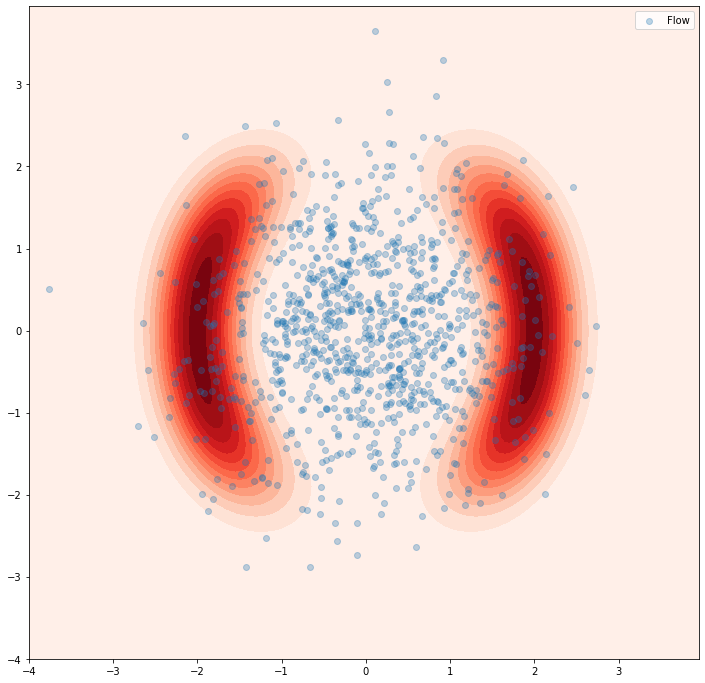

 16%|█▋        | 33/200 [00:03<00:18,  9.11it/s]

[[-0.0022454  -0.0020376   0.00022021 -0.00649707  0.0045878 ]
 [ 0.          0.         -0.00050187  0.01422854  0.00159047]]
[[-0.02134765  0.00564409  0.00645876 -0.05210958 -0.05567119]
 [ 0.          0.         -0.00420144  0.03453827 -0.04287624]]
[[-0.01130794 -0.00664848  0.00239455  0.00627255  0.01071063]
 [ 0.          0.         -0.01367894 -0.03495827  0.00752849]]


 18%|█▊        | 37/200 [00:03<00:14, 11.08it/s]

[[-0.03266843 -0.00983681 -0.02262287 -0.01795798 -0.00081281]
 [ 0.          0.         -0.02011159 -0.01556377  0.04263467]]
[[-0.0009539  -0.00609255  0.01026623  0.00499939  0.00101069]
 [ 0.          0.         -0.00801498 -0.00363272  0.03044635]]
[[-0.07722924  0.03514304  0.02324256 -0.06072919 -0.05614389]
 [ 0.          0.          0.01707524 -0.04450353 -0.00025032]]
[[-0.00088177 -0.00571387  0.00242688 -0.00362854  0.00232581]
 [ 0.          0.          0.0161663  -0.0242163   0.00605645]]


 20%|█▉        | 39/200 [00:04<00:14, 10.95it/s]

[[-0.05981614  0.05505579  0.07310137  0.0053249  -0.0484678 ]
 [ 0.          0.         -0.01290364 -0.00087252  0.01705184]]
[[-0.03491245 -0.09572424  0.00353238 -0.01856801  0.01669108]
 [ 0.          0.         -0.00074198  0.00389705 -0.00129434]]
[[ 0.01591515 -0.02160514 -0.00892199  0.02259151 -0.02953691]
 [ 0.          0.          0.00071837 -0.00186291 -0.01374492]]


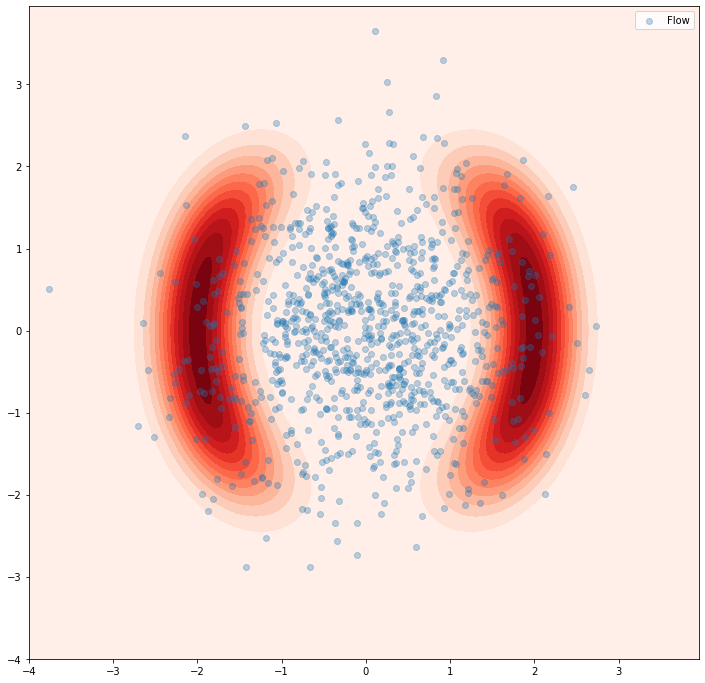

 22%|██▏       | 44/200 [00:04<00:16,  9.67it/s]

[[-0.01859308  0.00613397  0.0056263   0.0028452  -0.00462945]
 [ 0.          0.          0.00347094  0.00173977 -0.00462205]]
[[ 0.02749627  0.17616199 -0.01254692  0.0120075   0.01068617]
 [ 0.          0.          0.00475673 -0.00459529 -0.01140869]]
[[ 0.00074141  0.00037452 -0.00621542  0.00088952  0.0100897 ]
 [ 0.          0.         -0.02438198  0.00315867 -0.00481275]]
[[ 0.02235138 -0.03636672 -0.00818527 -0.05265962  0.15907342]
 [ 0.          0.         -0.0108373  -0.07561324 -0.06567178]]


 24%|██▍       | 48/200 [00:04<00:13, 11.26it/s]

[[0.01094604 0.00535622 0.00734827 0.00906001 0.11110426]
 [0.         0.         0.00162815 0.0019161  0.01531148]]
[[ 0.01067779  0.01875457 -0.04780859 -0.02410852 -0.04236435]
 [ 0.          0.          0.01179282  0.00553471 -0.03711168]]
[[-5.50702367e-02  2.23592347e-02 -1.80632366e-03  8.65167167e-05
   8.15153053e-03]
 [ 0.00000000e+00  0.00000000e+00 -7.02926531e-03  1.90617745e-04
   1.27514222e-02]]
[[ 0.02417511 -0.02860293  0.00538238 -0.01247165  0.02926911]
 [ 0.          0.          0.02135222 -0.04968942  0.047956  ]]


 25%|██▌       | 50/200 [00:05<00:12, 11.64it/s]

[[-0.01567128 -0.01841868  0.01697709  0.03795659 -0.02827032]
 [ 0.          0.          0.00192726  0.00412538 -0.01834558]]
[[-0.00659168 -0.00253345  0.00029277  0.00052417 -0.01318572]
 [ 0.          0.         -0.00392826 -0.00914244  0.00542577]]


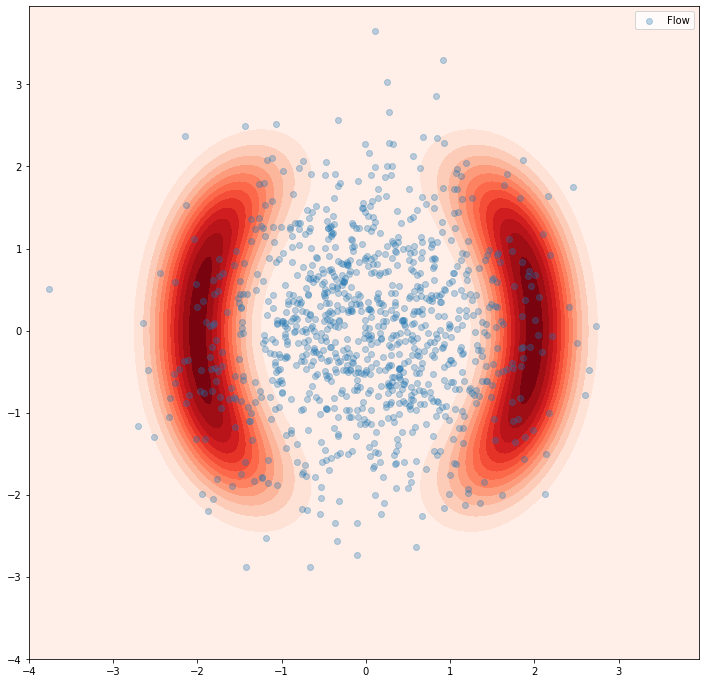

 27%|██▋       | 54/200 [00:05<00:15,  9.47it/s]

[[-0.00715177 -0.00712672  0.00322498  0.00730459 -0.07598869]
 [ 0.          0.          0.00161583  0.00475438  0.04793743]]
[[-0.00783337  0.01218427  0.00604401  0.02465377  0.05036258]
 [ 0.          0.          0.00039142  0.00112156 -0.02749358]]
[[-0.00390282 -0.00273681 -0.00484173 -0.00815763 -0.00710183]
 [ 0.          0.         -0.00545166 -0.0089249   0.01572047]]


 28%|██▊       | 56/200 [00:05<00:13, 10.60it/s]

[[-0.04889899  0.02807582  0.0029162  -0.00308436  0.02702668]
 [ 0.          0.          0.01734373 -0.01943465 -0.03594865]]
[[-7.36203678e-05 -2.49836287e-02 -1.09311746e-02  3.91223350e-03
   3.04672771e-02]
 [ 0.00000000e+00  0.00000000e+00  2.85097425e-02 -9.42515147e-03
   3.07427967e-02]]
[[0.01693066 0.02448117 0.00059061 0.01528738 0.02298089]
 [0.         0.         0.00023041 0.00674634 0.0234531 ]]


 30%|███       | 60/200 [00:06<00:11, 12.10it/s]

[[-0.04218295  0.01004363  0.0389159   0.01550275 -0.02081077]
 [ 0.          0.         -0.04224002 -0.01644478  0.06728995]]
[[ 0.03450284 -0.05763633 -0.04932407 -0.04189787 -0.00666878]
 [ 0.          0.          0.02893489  0.02434957 -0.02011266]]
[[-0.06148773 -0.08947727 -0.03916865  0.02146422 -0.09464148]
 [ 0.          0.          0.11583726 -0.06566067 -0.047491  ]]
[[-0.03481381 -0.01800048 -0.01359467 -0.00605366  0.00141629]
 [ 0.          0.         -0.00490629 -0.00200001  0.02201984]]


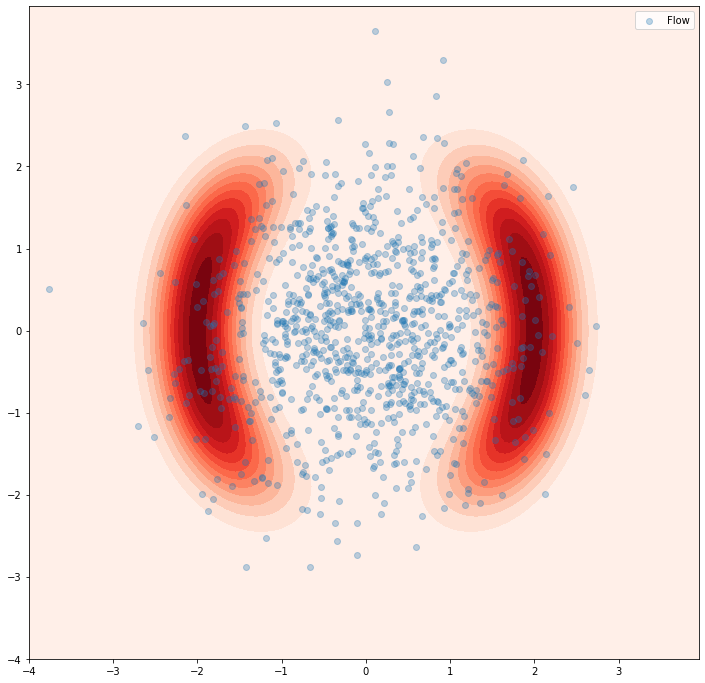

 32%|███▏      | 64/200 [00:06<00:15,  8.80it/s]

[[ 0.00547612 -0.02773378  0.01878586 -0.0139547  -0.03403743]
 [ 0.          0.         -0.05116716  0.03704463 -0.06034678]]
[[-0.0168372  -0.02204262 -0.00019111  0.00020002  0.00547683]
 [ 0.          0.          0.00334901 -0.00292229  0.00129548]]
[[ 0.0325347   0.0120272  -0.0119974   0.01029795 -0.00316093]
 [ 0.          0.         -0.00837435  0.00709077 -0.01850189]]


 33%|███▎      | 66/200 [00:06<00:13,  9.78it/s]

[[ 0.0059163   0.01259963  0.03196116 -0.01143658  0.00105145]
 [ 0.          0.          0.01109261 -0.0039622   0.00137209]]
[[-0.02044445 -0.02251689  0.00103416 -0.00372313  0.01049706]
 [ 0.          0.         -0.0025888   0.00932071 -0.01954394]]
[[-0.01202955 -0.00148401  0.01082158 -0.01846327  0.00332449]
 [ 0.          0.         -0.00510538  0.00885329  0.03107624]]


 35%|███▌      | 70/200 [00:07<00:11, 10.88it/s]

[[-0.02877608  0.00908805  0.02957738  0.02203389 -0.02094476]
 [ 0.          0.         -0.00746209 -0.00543259  0.01910197]]
[[ 0.05544954 -0.02866705  0.02992953 -0.01003235  0.04372268]
 [ 0.          0.          0.04466262 -0.01467934  0.10695578]]
[[ 0.00127047  0.00167731 -0.00305564 -0.00134204 -0.01070171]
 [ 0.          0.         -0.00177101 -0.00072074  0.00050654]]
[[ 0.01115882  0.02065968  0.00533698  0.0055822   0.05029144]
 [ 0.          0.         -0.02190144 -0.02112395 -0.02017542]]


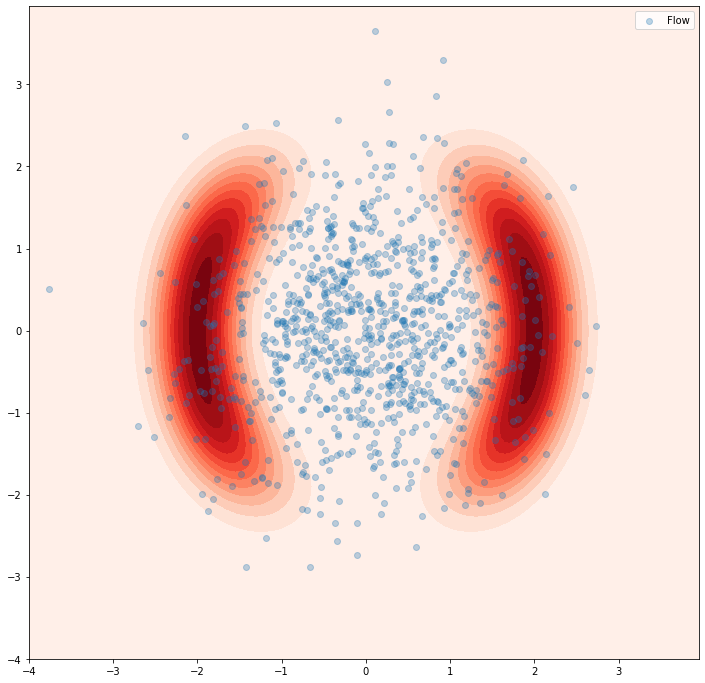

 37%|███▋      | 74/200 [00:07<00:14,  8.74it/s]

[[ 0.03595936  0.01364981 -0.07538578  0.01213768 -0.01750678]
 [ 0.          0.         -0.01371067  0.0022466   0.00211452]]
[[-0.07635784 -0.0142613   0.00695758 -0.00828662  0.02129965]
 [ 0.          0.          0.02632969 -0.03190819 -0.02139004]]
[[ 0.01788135  0.00259692 -0.00079864 -0.00499217 -0.06507132]
 [ 0.          0.          0.00526404  0.02563482  0.00631317]]


 38%|███▊      | 76/200 [00:08<00:13,  9.06it/s]

[[ 0.02636844 -0.00159939 -0.0153375   0.00342891  0.03251024]
 [ 0.          0.         -0.03082623  0.00550127 -0.12497196]]
[[-0.01665519  0.01628616  0.00963242  0.03046115  0.00483636]
 [ 0.          0.          0.00550135  0.01775934  0.0288932 ]]
[[-0.03445527 -0.03733206  0.07418783 -0.05258996 -0.01406424]
 [ 0.          0.         -0.03642823  0.02568477 -0.01481846]]


 39%|███▉      | 78/200 [00:08<00:12,  9.71it/s]

[[-0.02862361 -0.00166501  0.0038783  -0.0044912  -0.00969401]
 [ 0.          0.          0.00272989 -0.00319949 -0.01377144]]
[[-0.01150648 -0.02130953  0.00240026  0.00669859 -0.00167172]
 [ 0.          0.          0.00236138  0.00614532 -0.03527523]]


 40%|████      | 80/200 [00:08<00:13,  9.01it/s]

[[-0.02169111 -0.00614445 -0.01925759  0.00021839  0.02597575]
 [ 0.          0.          0.0283416  -0.00031642 -0.03800114]]
[[ 0.03451994 -0.02997541  0.00149333 -0.00050372 -0.01015887]
 [ 0.          0.          0.06319821 -0.01778222  0.064495  ]]


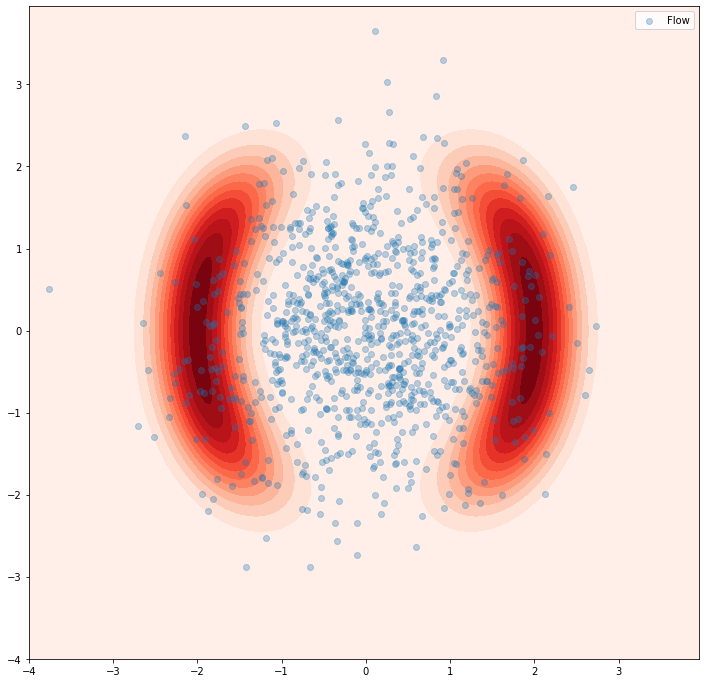

 42%|████▏     | 84/200 [00:09<00:16,  7.02it/s]

[[ 0.00989924 -0.00927619  0.01082958  0.0046446   0.01506101]
 [ 0.          0.         -0.01719992 -0.00712905  0.0050478 ]]
[[-0.00682776 -0.00087749  0.00438609 -0.00177599 -0.02038933]
 [ 0.          0.         -0.00219586  0.00086049  0.00610864]]
[[-0.01189325 -0.02527144  0.03233471 -0.03133346 -0.02640347]
 [ 0.          0.         -0.07898     0.07598833 -0.02891423]]


 43%|████▎     | 86/200 [00:09<00:14,  7.63it/s]

[[ 0.01498315  0.02621609  0.06061866  0.03245053  0.02555041]
 [ 0.          0.          0.00038206 -0.00038159 -0.06679195]]
[[ 0.058426   -0.00928476 -0.0033953   0.00733896 -0.03577973]
 [ 0.          0.          0.01199243 -0.0263083   0.01195165]]


 44%|████▍     | 88/200 [00:09<00:12,  8.78it/s]

[[-0.0120035  -0.0113576  -0.00163433 -0.00119412  0.01845666]
 [ 0.          0.         -0.00678695 -0.00558461  0.00972015]]
[[-0.03341144  0.05761144  0.05103492 -0.01139783 -0.10179186]
 [ 0.          0.          0.11836147 -0.0247578  -0.00712811]]
[[-0.00104144  0.01220119 -0.01511249  0.02187564  0.01727316]
 [ 0.          0.          0.00325482 -0.00464087  0.0107523 ]]


 45%|████▌     | 90/200 [00:09<00:11,  9.45it/s]

[[-7.94229553e-03  1.03720597e-02  2.80046390e-02 -4.18050677e-03
  -2.63966347e-02]
 [ 0.00000000e+00  0.00000000e+00  4.89055971e-04  1.34347142e-05
   1.11718454e-02]]
[[-0.05372294 -0.03124392  0.0143151  -0.00642539 -0.00044752]
 [ 0.          0.         -0.01732078  0.00804186  0.03907028]]


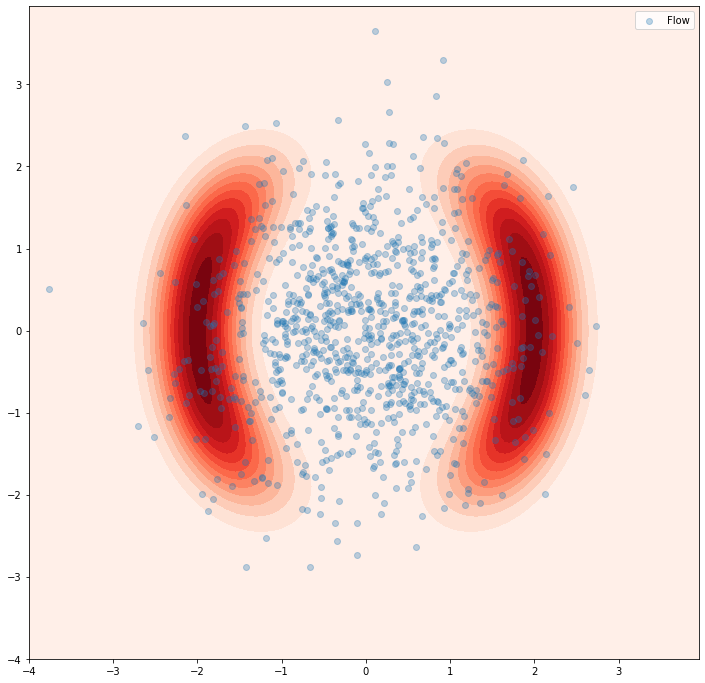

 46%|████▋     | 93/200 [00:10<00:13,  7.74it/s]

[[ 0.00190326 -0.01519077  0.00722258 -0.00329765  0.01496842]
 [ 0.          0.         -0.02335453  0.01100863  0.0023653 ]]
[[ 0.10265713 -0.02299505 -0.01686783 -0.01204815 -0.0330302 ]
 [ 0.          0.          0.05603294  0.03938493  0.03923405]]
[[-0.02217684  0.00143015 -0.00062476  0.00106165 -0.00731272]
 [ 0.          0.         -0.0029459   0.0051935   0.00907664]]


 48%|████▊     | 95/200 [00:10<00:12,  8.61it/s]

[[-0.03538774  0.00648961  0.01597986  0.02519253 -0.03347721]
 [ 0.          0.          0.01572085  0.02531755  0.01652998]]
[[ 0.00016012 -0.00642908  0.0028514  -0.00026001 -0.08325122]
 [ 0.          0.         -0.02268738 -0.00327607 -0.00628663]]


 50%|████▉     | 99/200 [00:10<00:10,  9.74it/s]

[[-0.02081199  0.03880085  0.02485785 -0.02068222 -0.02445269]
 [ 0.          0.         -0.01383124  0.01135948 -0.01089116]]
[[ 2.01104148e-03  9.26224620e-03 -7.33055504e-03  9.11560614e-04
  -1.48014772e-03]
 [ 0.00000000e+00  0.00000000e+00 -2.13974594e-04  7.08923939e-05
   5.88973299e-03]]
[[-0.03449596  0.00674254 -0.02647202 -0.04204911  0.06611082]
 [ 0.          0.          0.04589313  0.07439596  0.0242246 ]]
[[-0.03044553 -0.01897361 -0.00294892  0.00375383  0.00614207]
 [ 0.          0.         -0.01097685  0.0138687   0.00283138]]
[[ 0.00411745  0.0157445  -0.00595964  0.00243955  0.00433921]
 [ 0.          0.          0.00559376 -0.00224296  0.0027168 ]]


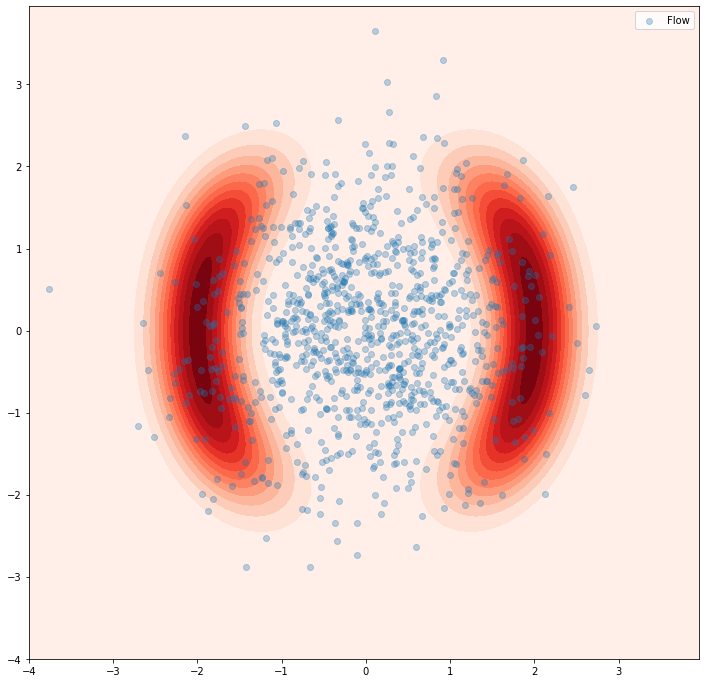

 52%|█████▏    | 103/200 [00:11<00:11,  8.60it/s]

[[-0.03892382 -0.0984212  -0.0031365  -0.01539134  0.00797979]
 [ 0.          0.         -0.00751305 -0.0364036   0.04567134]]
[[-7.62423940e-03 -3.19919617e-02  3.78862449e-02 -2.54746163e-04
  -8.74353847e-03]
 [ 0.00000000e+00  0.00000000e+00  1.39788136e-02  3.01999293e-05
   1.28890692e-02]]
[[ 0.00364003  0.00568739  0.0243415   0.00445859  0.02809048]
 [ 0.          0.         -0.00917629 -0.00128198  0.03904966]]


 54%|█████▎    | 107/200 [00:11<00:09,  9.94it/s]

[[-0.09120577  0.10524676  0.04101996 -0.00541746 -0.03166814]
 [ 0.          0.         -0.10379446  0.01327742  0.02381013]]
[[-0.05291395  0.02491462 -0.01202913  0.00623688  0.02635563]
 [ 0.          0.         -0.03064901  0.01567136  0.03392105]]
[[ 1.49899832e-02  3.13572925e-03 -6.58154256e-05  6.00518355e-04
  -1.17109317e-02]
 [ 0.00000000e+00  0.00000000e+00  3.55098787e-04 -2.72851858e-03
  -4.09541595e-03]]


 55%|█████▍    | 109/200 [00:11<00:08, 10.17it/s]

[[ 0.05879582 -0.05836546  0.03266796 -0.02414659  0.03673919]
 [ 0.          0.         -0.03070775  0.02278335 -0.02051318]]
[[-0.08925471 -0.00187086 -0.0140555  -0.01315417  0.01248314]
 [ 0.          0.          0.04209155  0.03907399 -0.07178117]]
[[ 0.00512482  0.02114289 -0.00830245 -0.04120788  0.00412608]
 [ 0.          0.          0.0026952   0.01421013  0.04648954]]
[[ 0.01501839 -0.03621727 -0.004234    0.00081035 -0.02826394]
 [ 0.          0.         -0.07797891  0.01854764 -0.02004389]]


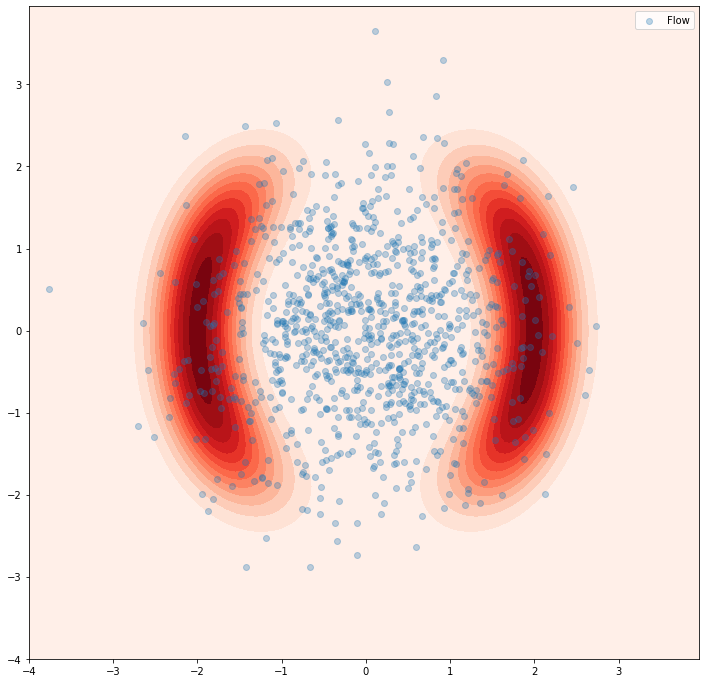

 57%|█████▋    | 114/200 [00:12<00:09,  9.15it/s]

[[ 0.01487547  0.02068049  0.01511752  0.00988819 -0.00365721]
 [ 0.          0.         -0.02784346 -0.01867899 -0.04521089]]
[[ 0.04107394 -0.02016639 -0.0043039   0.00440233  0.00742115]
 [ 0.          0.         -0.01944506  0.01945464 -0.04276335]]
[[ 1.59271233e-02  1.48824636e-02 -1.08174316e-02 -5.14668978e-04
  -1.57947359e-02]
 [ 0.00000000e+00  0.00000000e+00 -2.09577580e-03 -1.35358849e-05
   8.02374109e-03]]


 59%|█████▉    | 118/200 [00:12<00:07, 11.26it/s]

[[ 0.00032965 -0.02054783  0.00228651  0.00462005 -0.01374721]
 [ 0.          0.         -0.00047184 -0.0008611   0.01064541]]
[[-0.0017258   0.02004317 -0.00532641 -0.0049332   0.05136787]
 [ 0.          0.          0.01571631  0.01662633  0.062     ]]
[[ 0.0303309  -0.01319691 -0.01131523  0.02828931 -0.01582115]
 [ 0.          0.          0.00252827 -0.00621368  0.04125327]]
[[ 0.03874306 -0.068906    0.00657821 -0.00191511  0.00296549]
 [ 0.          0.         -0.00601841  0.00172595 -0.00637384]]


 60%|██████    | 120/200 [00:12<00:07, 11.40it/s]

[[ 2.22846815e-02 -6.89790838e-03 -3.81262795e-02  3.96138055e-02
  -4.18393523e-02]
 [ 0.00000000e+00  0.00000000e+00 -9.72692891e-05  1.44344976e-04
   7.52524773e-03]]
[[ 7.51127634e-03  8.14482092e-02  5.54192212e-04 -5.31713542e-02
  -7.11835567e-02]
 [ 0.00000000e+00  0.00000000e+00  6.72403403e-05 -6.30886894e-03
  -9.25829778e-03]]
[[-0.05824484 -0.04090659  0.01117575 -0.02897261  0.01002979]
 [ 0.          0.          0.00820646 -0.02131263 -0.00573456]]


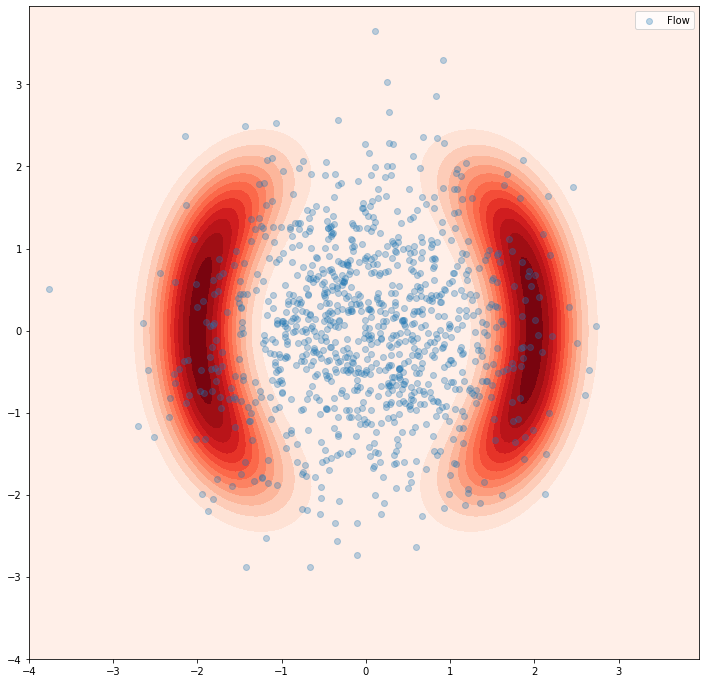

 62%|██████▏   | 124/200 [00:13<00:08,  9.05it/s]

[[ 0.01396644 -0.00964055  0.00097951 -0.00616666  0.01731542]
 [ 0.          0.         -0.00018486  0.00116338 -0.00326951]]
[[ 0.00677545 -0.00894174  0.00850982 -0.00155118  0.07303732]
 [ 0.          0.         -0.01539337  0.00392881  0.02305625]]
[[ 3.78625634e-03  3.29830970e-03 -3.81855525e-04  8.77326474e-03
   8.58033375e-03]
 [ 0.00000000e+00  0.00000000e+00  8.31292597e-05 -7.48918417e-04
  -3.15773365e-02]]


 63%|██████▎   | 126/200 [00:13<00:07,  9.90it/s]

[[ 0.02127204  0.01005685 -0.03154193  0.01659062 -0.0247962 ]
 [ 0.          0.         -0.00083671  0.00056513  0.01808925]]
[[ 0.0065674   0.01779354  0.01953382 -0.00787981  0.03424538]
 [ 0.          0.          0.03629236 -0.01521724 -0.02021219]]
[[-0.02142224  0.00329358 -0.02050298 -0.01883485  0.0686694 ]
 [ 0.          0.          0.02637713  0.02540776  0.03498413]]


 65%|██████▌   | 130/200 [00:13<00:06, 11.36it/s]

[[ 0.06069245 -0.00381929 -0.00867911  0.00763749  0.00807046]
 [ 0.          0.         -0.00804609  0.00681703 -0.03679636]]
[[-0.00106462 -0.01023678 -0.00881843 -0.0042562   0.0051384 ]
 [ 0.          0.          0.00644654  0.00318981  0.00528815]]
[[-0.00717973  0.02685666  0.01056986 -0.00784253 -0.05889982]
 [ 0.          0.          0.03214626 -0.02279266 -0.01230154]]
[[ 0.01730083 -0.01645252 -0.01101706 -0.01066959  0.01157923]
 [ 0.          0.          0.00782836  0.00783093  0.01762662]]


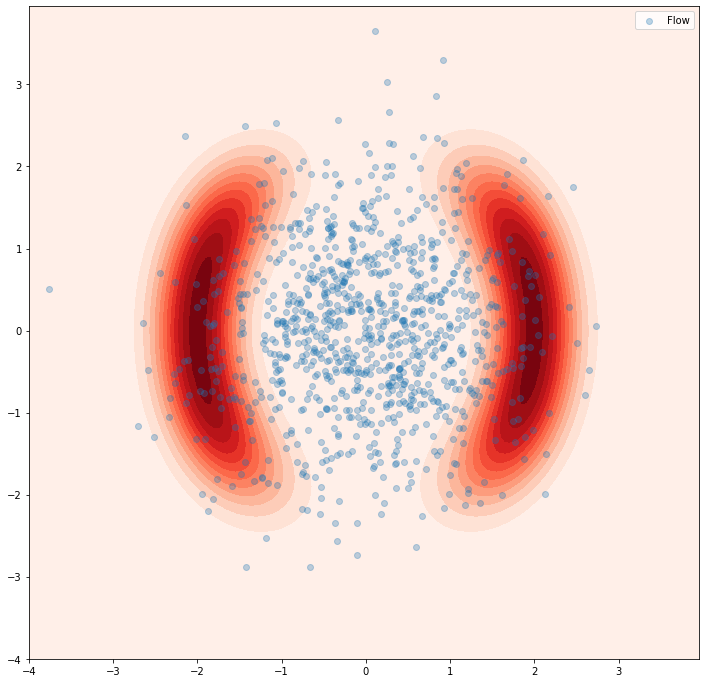

 67%|██████▋   | 134/200 [00:14<00:07,  9.22it/s]

[[-0.01438964 -0.00744835  0.00776617 -0.00636583  0.03074639]
 [ 0.          0.         -0.02600802  0.02207637  0.02205594]]
[[-0.02661348  0.026003   -0.07823236 -0.00191475 -0.07607829]
 [ 0.          0.         -0.14626115 -0.00192563  0.07248042]]
[[-2.27915475e-03 -2.93430586e-03  1.13953844e-03  3.70318828e-05
  -1.66740981e-02]
 [ 0.00000000e+00  0.00000000e+00  9.48492632e-03  1.33590343e-03
  -1.03947054e-02]]


 68%|██████▊   | 136/200 [00:14<00:06, 10.27it/s]

[[-0.00040411 -0.00611278  0.0024921   0.00054675 -0.00029274]
 [ 0.          0.         -0.00269548 -0.00056471  0.00358959]]
[[ 0.0101855  -0.02996587  0.04188232  0.01888102 -0.01737999]
 [ 0.          0.          0.0153354   0.00728959  0.03723992]]
[[ 0.01788288  0.00493976  0.00519681  0.02822563  0.04284442]
 [ 0.          0.         -0.00459815 -0.02401045  0.01508591]]


 70%|███████   | 140/200 [00:14<00:05, 11.97it/s]

[[ 0.02019717  0.0070068  -0.00336784 -0.00395488  0.03724214]
 [ 0.          0.          0.01767649  0.02306378  0.02970478]]
[[ 0.00254577 -0.00171628 -0.00311004  0.00281501 -0.01244414]
 [ 0.          0.         -0.00035088  0.00015997 -0.02817562]]
[[ 0.00619983 -0.02954228  0.00361179 -0.0432198   0.06631075]
 [ 0.          0.          0.00256586 -0.0301191   0.01045777]]
[[ 0.03025191  0.0321137  -0.06119905  0.01677354  0.01947238]
 [ 0.          0.         -0.06222937  0.01672013 -0.02714257]]


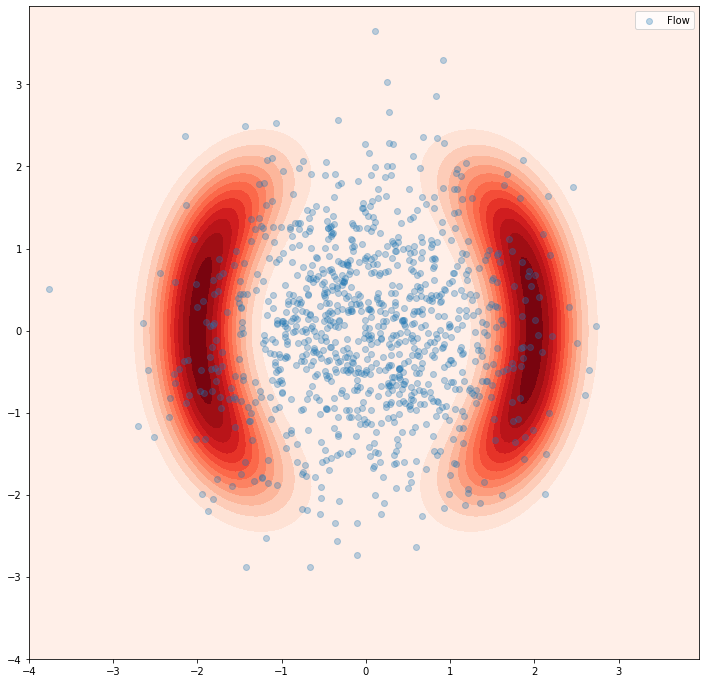

 72%|███████▏  | 144/200 [00:15<00:06,  9.31it/s]

[[ 0.00493861 -0.04183114 -0.0019212   0.05212697 -0.01642476]
 [ 0.          0.          0.00018033 -0.00627257  0.03222999]]
[[-0.02270544 -0.04271812 -0.00971505  0.03267448 -0.00347875]
 [ 0.          0.          0.00319739 -0.01074367  0.00938417]]
[[ 0.00164937  0.00543605  0.00022919 -0.00333468  0.00141944]
 [ 0.          0.         -0.00016347  0.0021945   0.00788903]]


 73%|███████▎  | 146/200 [00:15<00:05, 10.24it/s]

[[-0.01785457 -0.00441726 -0.0095763   0.0177276   0.01203634]
 [ 0.          0.         -0.00489378  0.00900811 -0.00624382]]
[[-0.09362652 -0.08008247  0.00195303  0.01767604 -0.02800995]
 [ 0.          0.         -0.00027117 -0.00284079 -0.01118526]]
[[-0.00990154  0.04462965  0.01651103  0.06768996  0.02924731]
 [ 0.          0.         -0.00373711 -0.01562434 -0.02577516]]


 75%|███████▌  | 150/200 [00:15<00:04, 11.28it/s]

[[ 0.00678867 -0.01595962  0.00480176 -0.01808918 -0.01352839]
 [ 0.          0.          0.00359104 -0.01350515  0.06530235]]
[[-0.00052876 -0.05103654  0.02141305  0.02575287 -0.00569421]
 [ 0.          0.          0.02196825  0.02542928 -0.1035288 ]]
[[-1.84121743e-02  1.29691857e-02 -9.45868520e-03 -8.66613501e-02
  -1.64936902e-02]
 [ 0.00000000e+00  0.00000000e+00  6.96519684e-05 -1.00202368e-03
  -6.41388464e-02]]
[[-0.01623021 -0.02028732  0.01103346  0.01615545 -0.05326835]
 [ 0.          0.         -0.00042139 -0.00121542 -0.05404584]]


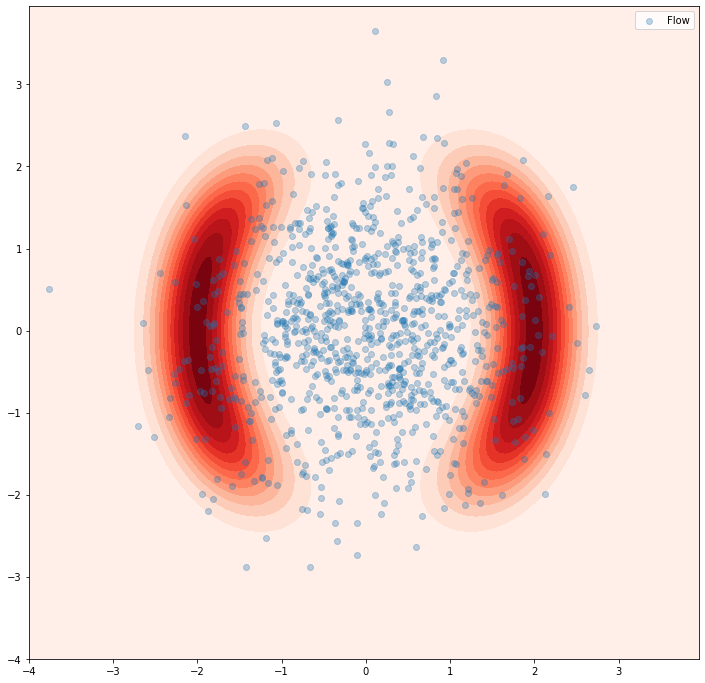

 77%|███████▋  | 154/200 [00:16<00:04,  9.41it/s]

[[ 0.00696974 -0.01969474 -0.00375386  0.00674126 -0.02019235]
 [ 0.          0.          0.00629251 -0.0113979   0.00978349]]
[[-0.02963905 -0.01506163 -0.00166751  0.00653329 -0.00042748]
 [ 0.          0.         -0.00133615  0.00523509 -0.00032428]]
[[-0.03367323 -0.02975833  0.06504326  0.01309571 -0.01911795]
 [ 0.          0.          0.02235591  0.00426451 -0.03579935]]


 79%|███████▉  | 158/200 [00:16<00:03, 11.17it/s]

[[-0.05773545  0.04462306 -0.00506505 -0.00506817 -0.00061769]
 [ 0.          0.          0.0071501   0.00711522 -0.00324251]]
[[-0.04186455  0.01517884  0.0120962  -0.0003175  -0.0723679 ]
 [ 0.          0.          0.05260526  0.00036592 -0.0888529 ]]
[[-0.07218129 -0.02681154 -0.01516058  0.00934309  0.01474025]
 [ 0.          0.         -0.04545876  0.02795098  0.03343141]]
[[ 0.00824195 -0.04176065  0.00530013 -0.0147944   0.07976225]
 [ 0.          0.         -0.00982657  0.02748423 -0.12002873]]


 80%|████████  | 160/200 [00:16<00:03, 11.35it/s]

[[ 0.03776104 -0.02523634 -0.0123082  -0.00599784 -0.00672042]
 [ 0.          0.          0.00278345  0.00129195 -0.00590979]]
[[ 0.00421887 -0.0044482   0.00062106  0.00093306  0.00636979]
 [ 0.          0.          0.00101463  0.00132753 -0.00841566]]
[[-3.11442029e-03 -1.12838076e-03 -1.28840548e-03  3.15082644e-05
   6.76706947e-02]
 [ 0.00000000e+00  0.00000000e+00  1.02468262e-02  4.24032150e-03
  -1.26391663e-02]]


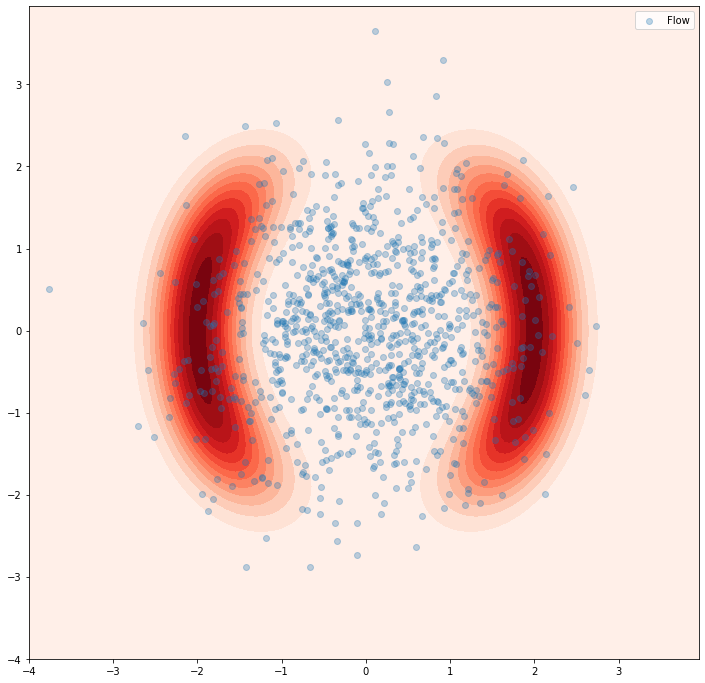

 82%|████████▏ | 164/200 [00:17<00:03,  9.45it/s]

[[ 0.10442065 -0.02045368 -0.02428417 -0.04789887  0.00019455]
 [ 0.          0.          0.02702225  0.05364004  0.0284966 ]]
[[-0.07963865  0.03187894  0.01614773  0.00771512  0.04375891]
 [ 0.          0.          0.11905787  0.05374481 -0.04448688]]
[[ 0.05114092 -0.01999343 -0.02658952  0.00477807  0.08904469]
 [ 0.          0.          0.10052771 -0.01495131  0.08350758]]
[[-0.02260499 -0.00376873  0.00885855 -0.00962301 -0.01496129]
 [ 0.          0.         -0.00020707  0.00029918  0.01360967]]


 84%|████████▍ | 168/200 [00:17<00:02, 11.10it/s]

[[ 0.00275906 -0.00353384 -0.00027705 -0.00041848 -0.01756313]
 [ 0.          0.          0.00213832  0.00190683 -0.00388929]]
[[-0.00928257 -0.02940285 -0.01490341 -0.05298095  0.10293106]
 [ 0.          0.         -0.00418403 -0.01725404 -0.13140475]]
[[ 0.00072793 -0.00425802  0.00059027  0.00162761 -0.0026124 ]
 [ 0.          0.         -0.00168725 -0.00381618  0.07061343]]


 85%|████████▌ | 170/200 [00:17<00:02, 11.28it/s]

[[-0.02152421  0.00041706  0.00356511  0.05604268  0.04663132]
 [ 0.          0.         -0.00362055 -0.05331577  0.04957535]]
[[ 0.00809009 -0.00438878 -0.00147025  0.0053696  -0.05701603]
 [ 0.          0.         -0.00439385  0.01611145 -0.04395489]]
[[ 0.0161771  -0.00234413 -0.01620292  0.10575377  0.00582185]
 [ 0.          0.         -0.00420303  0.0276417  -0.04118749]]


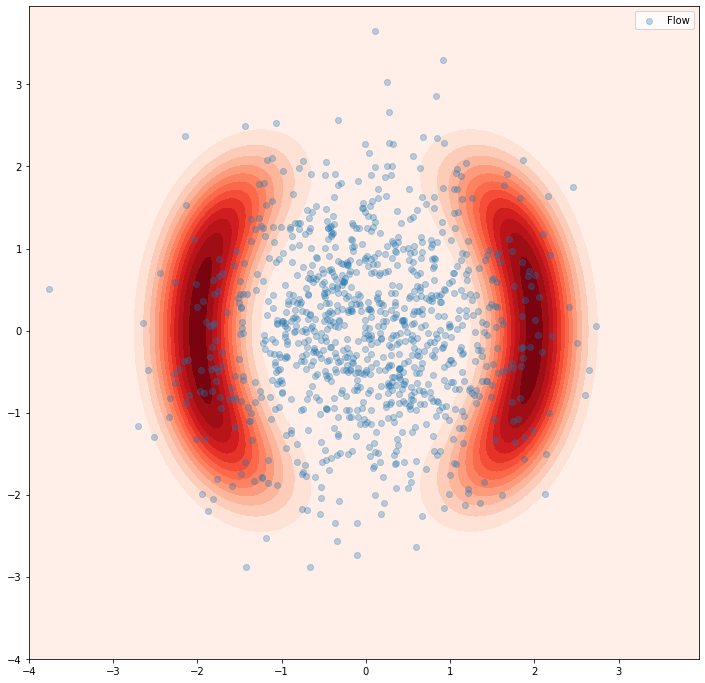

 87%|████████▋ | 174/200 [00:18<00:02,  9.28it/s]

[[-0.02620705  0.04398735  0.03639509  0.0199654  -0.00545081]
 [ 0.          0.          0.00840904  0.00479752  0.0198187 ]]
[[-4.80042955e-03 -4.63134460e-05 -1.39979754e-04  1.43848743e-02
   2.73549900e-03]
 [ 0.00000000e+00  0.00000000e+00 -3.62471194e-05  5.33195217e-03
  -7.30169024e-03]]
[[ 0.00349389  0.00164958  0.00262551 -0.00250899  0.00397931]
 [ 0.          0.         -0.00029963  0.00030518  0.00278586]]


 88%|████████▊ | 176/200 [00:18<00:02, 10.40it/s]

[[ 0.00629802  0.01461794  0.00347282 -0.02180543 -0.00867366]
 [ 0.          0.         -0.00503461  0.03163523  0.00587772]]
[[ 5.06614384e-03 -3.14650179e-03  1.52159650e-02  5.09322779e-05
  -8.11266504e-03]
 [ 0.00000000e+00  0.00000000e+00  3.26751276e-03  5.40860195e-04
   6.66669547e-02]]
[[-0.03098053  0.01883452 -0.00213334 -0.00249862  0.00119646]
 [ 0.          0.         -0.03352007 -0.03924811  0.0201257 ]]


 90%|█████████ | 180/200 [00:18<00:01, 11.56it/s]

[[ 0.01177726  0.10698584  0.00371811  0.00065111 -0.00869406]
 [ 0.          0.          0.03273989  0.00643103  0.00993416]]
[[-5.50210007e-05  1.30541308e-02  8.11726800e-03  1.10230558e-02
   3.98745879e-02]
 [ 0.00000000e+00  0.00000000e+00 -6.97082982e-03 -1.01687916e-02
  -1.02875712e-01]]
[[-0.04195214  0.04937986 -0.0173269   0.01654516  0.13764323]
 [ 0.          0.         -0.01950901  0.01779042  0.01351519]]
[[-0.01346316  0.00071041  0.00145648  0.00349068  0.00952646]
 [ 0.          0.          0.00408264  0.00937033 -0.00719352]]


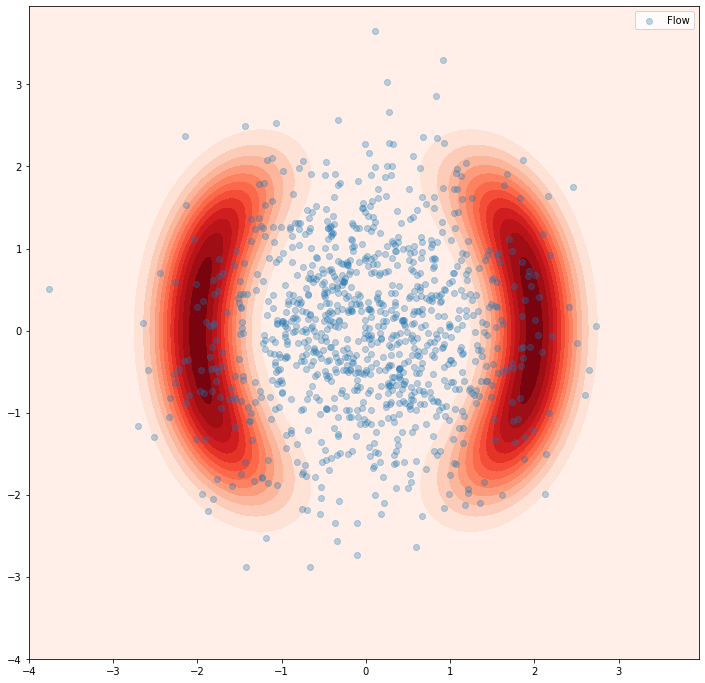

 92%|█████████▏| 184/200 [00:19<00:01,  9.36it/s]

[[ 0.00428113  0.05165548 -0.01696745  0.03826974  0.01415368]
 [ 0.          0.          0.01621493 -0.03668673 -0.04907622]]
[[ 0.00579626 -0.05166947  0.077889   -0.02102344  0.02849394]
 [ 0.          0.         -0.02489193  0.00674991 -0.0049323 ]]
[[-0.03134914  0.04956104 -0.00020548 -0.00365613 -0.00534064]
 [ 0.          0.         -0.00070023 -0.01252906 -0.020361  ]]


 93%|█████████▎| 186/200 [00:19<00:01, 10.56it/s]

[[-0.06325435  0.02575325 -0.00521294 -0.05479216 -0.06511172]
 [ 0.          0.         -0.00325253 -0.0320663   0.0378932 ]]
[[-0.00165379 -0.00212546 -0.0008143   0.00037562 -0.09460881]
 [ 0.          0.         -0.00218293  0.00255692  0.0261192 ]]
[[ 0.001985   -0.00790642  0.01435003 -0.00387929  0.00154959]
 [ 0.          0.          0.00919283 -0.00242532  0.00930729]]


 95%|█████████▌| 190/200 [00:19<00:00, 11.83it/s]

[[-0.01332167  0.00835532  0.00535048  0.00745544  0.00411148]
 [ 0.          0.          0.01235963  0.0170888  -0.00332035]]
[[ 0.06166856  0.00748074 -0.07666203 -0.04888718 -0.04892169]
 [ 0.          0.          0.00721728  0.00479021  0.02559182]]
[[ 4.38289305e-02 -7.41025209e-03  4.64441750e-03  5.63487096e-02
  -1.00152103e-02]
 [ 0.00000000e+00  0.00000000e+00 -4.35363270e-05 -2.73316180e-03
  -6.96163159e-02]]
[[ 0.040471   -0.00437073 -0.00528893  0.02260696 -0.02950733]
 [ 0.          0.          0.01836784 -0.07845723  0.00433441]]


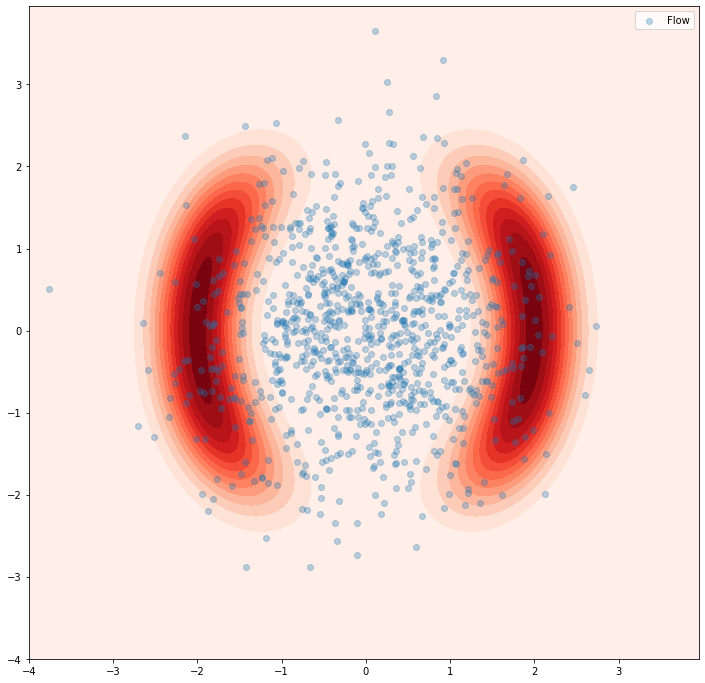

 97%|█████████▋| 194/200 [00:20<00:00,  9.86it/s]

[[-0.02593819  0.00216439 -0.01201884 -0.00749346  0.02675666]
 [ 0.          0.          0.01604147  0.00985721 -0.05171125]]
[[ 0.04462996  0.05596829 -0.00721454  0.02519228  0.01789508]
 [ 0.          0.          0.03871616 -0.13512146 -0.03233912]]
[[ 0.05130823  0.02265791  0.04575482 -0.0079156   0.04361888]
 [ 0.          0.         -0.0258903   0.00448287 -0.02371138]]


 99%|█████████▉| 198/200 [00:20<00:00, 11.60it/s]

[[-0.00302979 -0.02702482 -0.02538584 -0.01283895  0.00340758]
 [ 0.          0.          0.03706762  0.0186765  -0.01296012]]
[[ 0.03951862 -0.01578775 -0.00550104 -0.00969102  0.00092086]
 [ 0.          0.         -0.0013799  -0.00252685 -0.00837425]]
[[ 0.00316296 -0.00737211 -0.00174868  0.00157738  0.02328736]
 [ 0.          0.         -0.00485485  0.00343909 -0.08946703]]
[[ 0.03442998  0.00251363 -0.01994806  0.0313634  -0.00497121]
 [ 0.          0.         -0.00870673  0.0136872  -0.00261189]]


100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


[[-0.02792742 -0.01595428  0.01388145  0.076063   -0.06543597]
 [ 0.          0.          0.0320627   0.17833844 -0.00639529]]
[[0.12612691 0.07699731 0.07962565 0.00907663 0.04627655]
 [0.         0.         0.0682456  0.00778449 0.03863615]]
UPDATED PARAMETERS:
[[ 0.00131405 -0.00226817  0.00071807  0.0051074  -0.00418023]
 [-0.00363749  0.0021842  -0.00270837  0.00971418  0.00108603]]


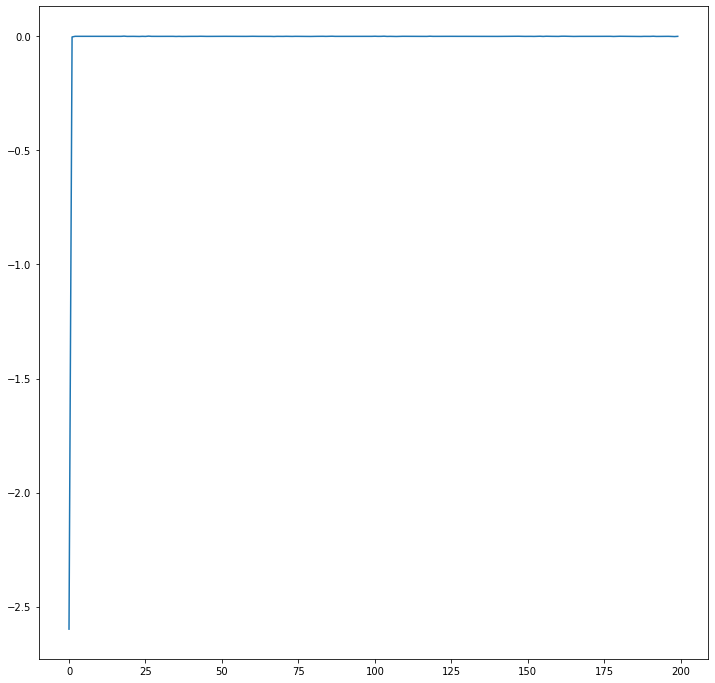

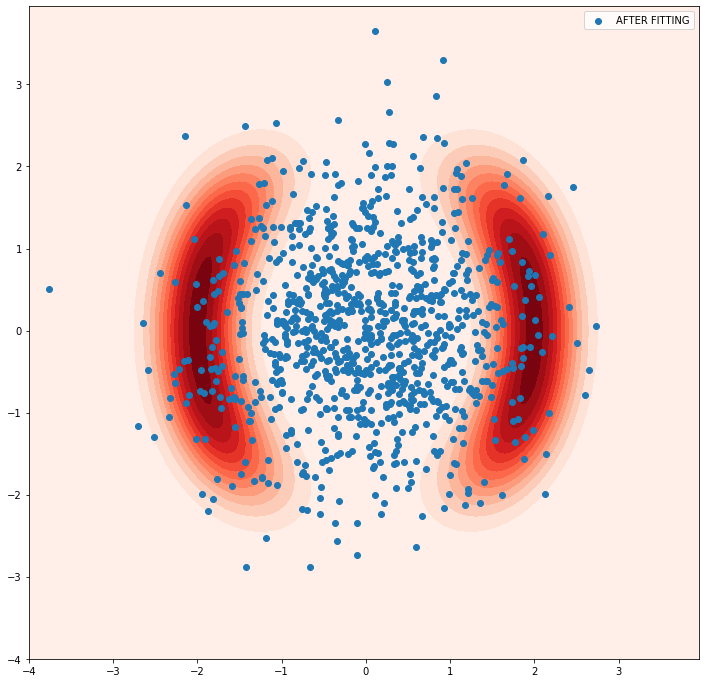

In [8]:
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

new_lambda = np.copy(lbda)
elbo = []
print("ORIGINAL LAMDA:\n{}\n".format(new_lambda))
fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(samples[:,0], samples[:,1])
plt.show()

for i in tqdm(range(200)):
    # Update model parameters
    grad_f_samples = grad_en_func(new_lambda)
    print(grad_f_samples)
    new_lambda = 0.0005*grad_f_samples + 0.005*np.random.randn(*grad_f_samples.shape)
    elbo.append(en_func(new_lambda))

    # Flow samples with new parameters
    new_flow_func = lambda z: flow(z, new_lambda[0], func)
    updated_flow_samples = new_flow_func(np.copy(samples))
    #print("UPDATED LAMBDA:\n{}\n".format(new_lambda))
    
    if i % 10 == 0:
        # Plot
        fig, ax = plt.subplots(figsize=(12,12))
        ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
        ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")    
        ax.legend(loc='best')
        plt.show()

print("UPDATED PARAMETERS:\n{}".format(new_lambda))
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(elbo, label="FREE ENERGY")
plt.show()

fig, ax = plt.subplots(figsize=(12,12))
ax.contourf(X, Y, u1(dat), cmap='Reds', levels=15) # Target distribution
ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], label="AFTER FITTING")
#ax.scatter(samples[:,0], samples[:,1], label="ORIGINAL DATA", color='k')
ax.legend(loc='best')
plt.show()

# Fitting my own single planar transformation

LAMBDA: [[0.5 0.5 0.5 0.5 0.5]]
[[102.33220617 102.33220617 321.48244911 -87.33327299 970.0902105 ]]


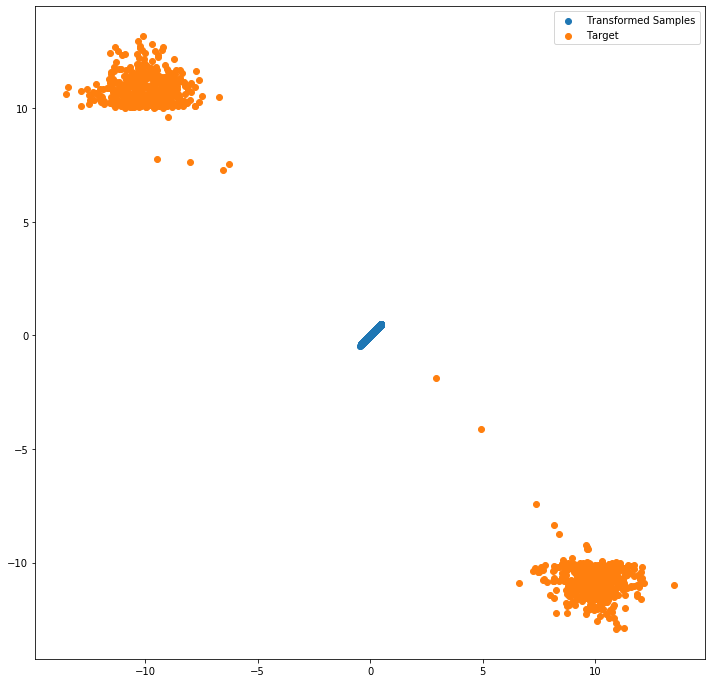

In [9]:
# Samples from initial distribution
samples = np.random.multivariate_normal([0,0], np.eye(2), 1000)

# Setting up flow parameters - splits data vertically, is a good example
#us = [np.array([3,0])]       #, np.array([0.5, 0.5]), np.array([-1, 1]), np.array([1, -1])]
#bs = [0]                     #, 1, 2, 3]
#ws = [np.array([15, 0])]     #, np.array([1,0]), np.array([0,1]), np.array([1,1])]
lbda = [np.array([-10., 10., 0., 150., 0.1])]


# Set up parameters for learning flow
flows = 1
func = lambda x: np.tanh(x)  # Function for transformation
#flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows
#target_samples = flow_samples(np.copy(samples), flow_func, lbda)
target_samples = flow(np.copy(samples), lbda[0], np.tanh)

lbda = np.array([np.ones(5)*0.5]*flows)
print("LAMBDA: {}".format(lbda))
flow_func = [lambda z, lbda: psi(z, lbda, grad(func))]*flows
func = lambda x: np.tanh(x)  # Function for transformation

p = lambda x: np.log(norm.pdf(x[1] - np.sin(x[0]), 0, 0.1))
p = lambda x: np.log(multivariate_normal.pdf(x, [3,3], [[1,-5],[0,1]]))
q = lambda z: np.log(multivariate_normal.pdf(z, [0,0], np.eye(2)))

en = free_energy(samples, lbda, q, p, flow_func, target_samples)
en_func = lambda lmda: free_energy(samples, lmda, q, p, flow_func, target_samples)
#print(samples.shape)
#print("ONE PARTICULAR LAMBDA: {}".format(en_func(lbda)))
grad_en_func = grad(en_func)
grad_f_samples = grad_en_func(lbda)
print(grad_f_samples)

# Generate new samples from flow
#print("LAMBDA: {}".format(lbda))
transformed_samples = flow_samples(samples, flow_func, lbda)
#print(transformed_samples.shape)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(transformed_samples[:,0], transformed_samples[:,1], label="Transformed Samples")
ax.scatter(target_samples[:,0], target_samples[:,1], label="Target")
ax.legend(loc='best')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

NEW LAMBDA BEFORE:
[[0.5 0.5 0.5 0.5 0.5]]
[[102.33220617 102.33220617 321.48244911 -87.33327299 970.0902105 ]]
[[ 1.52332206  1.52332206  3.71482449 -0.37333273 10.2009021 ]]


/home/elisionducoeur/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


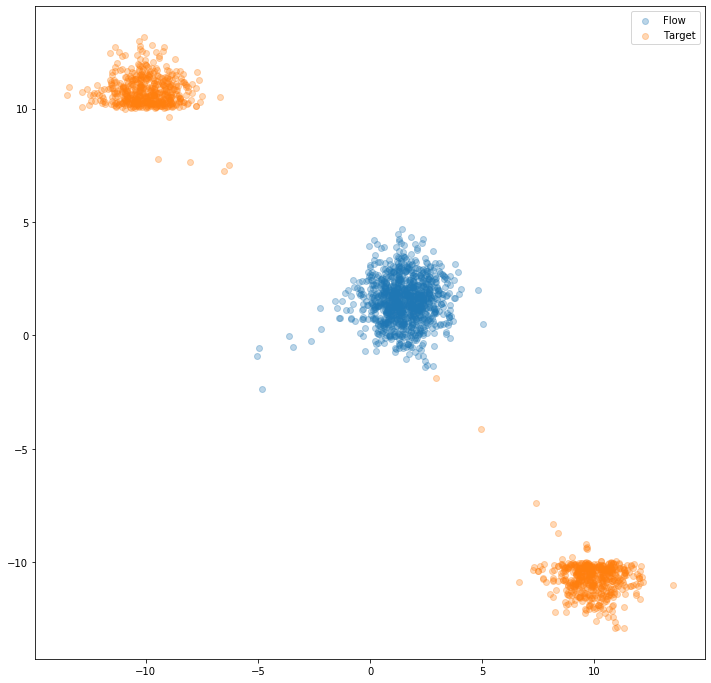

 10%|█         | 1/10 [00:00<00:02,  3.43it/s]

[[ 611.22562935  -61.42700235 1688.34854389  592.90673712   60.40557753]]
[[ 7.63557836  0.90905204 20.59830993  5.55573464 10.80495788]]


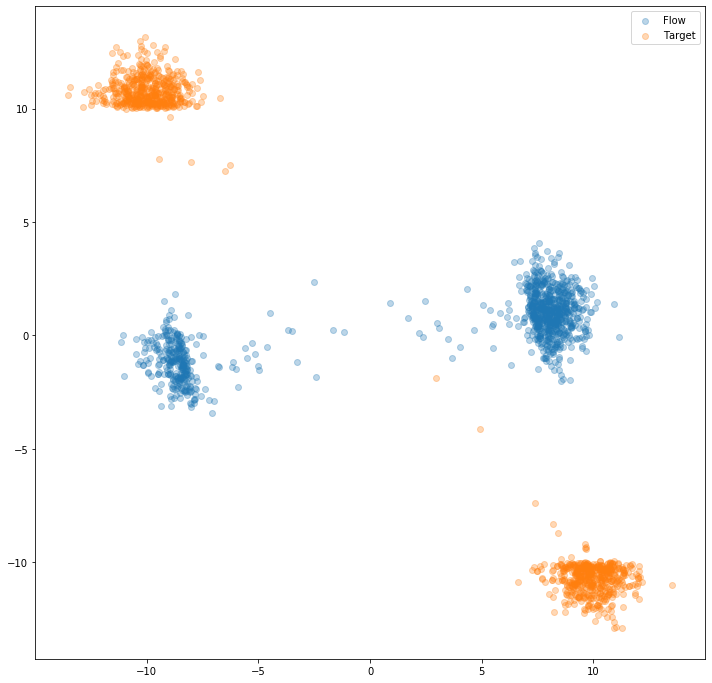

 20%|██        | 2/10 [00:00<00:02,  3.49it/s]

[[  126.61615267    34.15065352 -4601.2876984   -567.23691459
   1150.15251309]]
[[  8.90173988   1.25055857 -25.41456705  -0.1166345   22.30648301]]


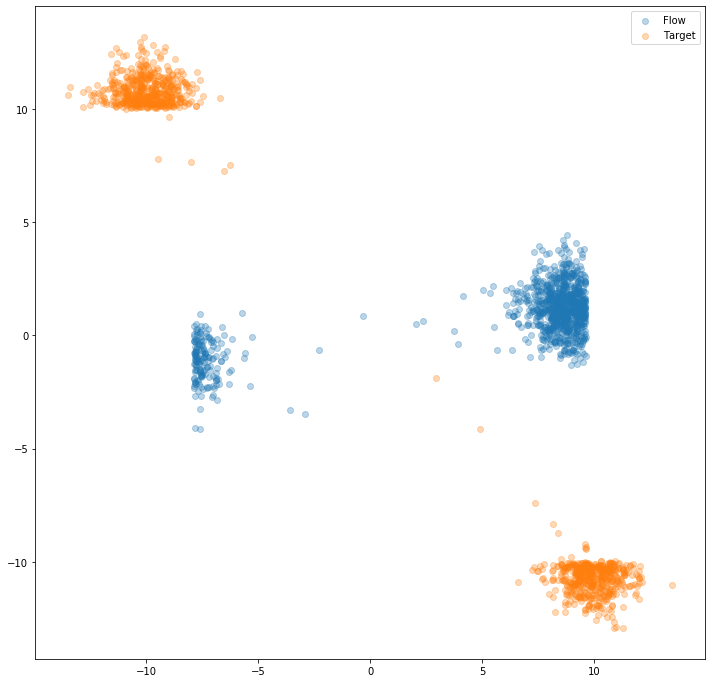

 30%|███       | 3/10 [00:00<00:02,  3.44it/s]

[[ 1.12600004e+02  5.16752680e-01  2.69755042e+03  1.37872458e+02
  -1.16904718e+03]]
[[10.02773992  1.2557261   1.56093717  1.26209008 10.61601123]]


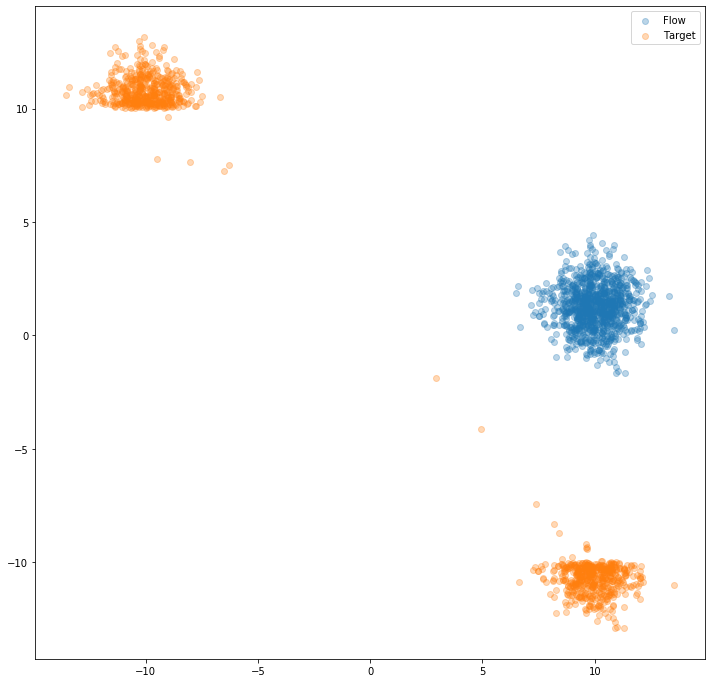

 40%|████      | 4/10 [00:01<00:01,  3.47it/s]

[[8.55893697e+01 6.92029740e+01 1.56269153e+03 2.42640873e+02
  4.05381328e-03]]
[[10.88363361  1.94775584 17.18785245  3.68849881 10.61605177]]


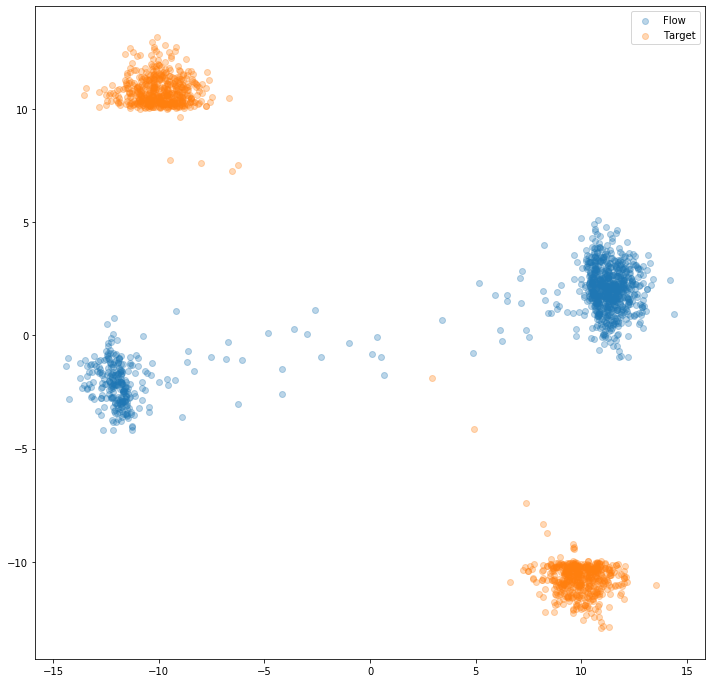

 50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

[[   88.27948002    18.94470281 -3287.89717117  -393.76119687
   1099.65353561]]
[[ 11.76642841   2.13720287 -15.69111926  -0.24911316  21.61258713]]


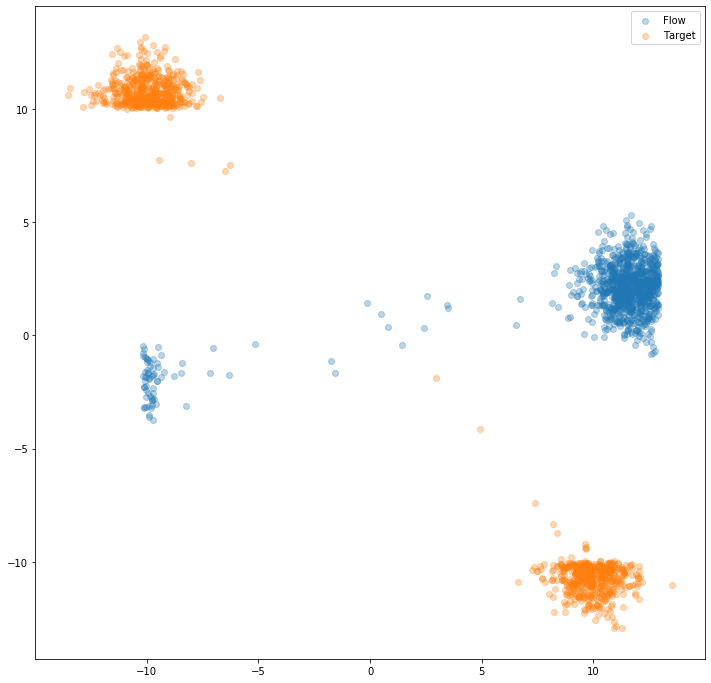

 60%|██████    | 6/10 [00:01<00:01,  3.54it/s]

[[ 8.49532123e+01  1.34872236e+00  1.71810954e+03  3.35403385e+02
  -1.04406220e+03]]
[[12.61596054  2.15069009  1.48997612  3.10492068 11.17196512]]


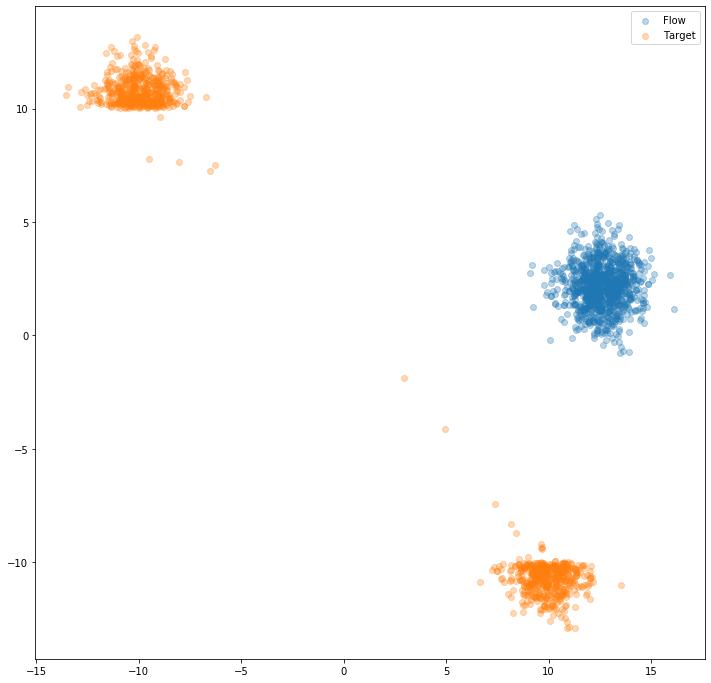

 70%|███████   | 7/10 [00:01<00:00,  3.64it/s]

[[5.62779452e+01 1.17276078e+02 5.74833928e+02 7.02083273e+01
  2.60003616e-01]]
[[13.17873999  3.32345088  7.2383154   3.80700396 11.17456515]]


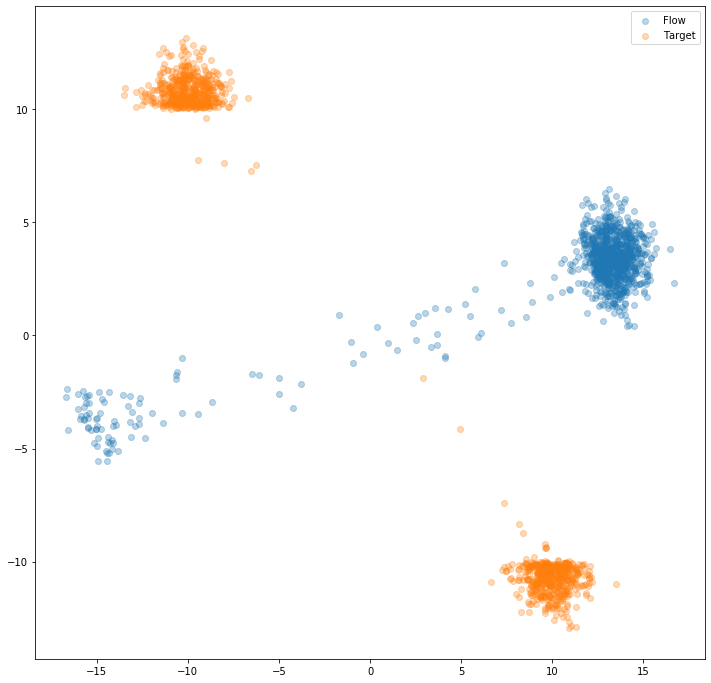

 80%|████████  | 8/10 [00:02<00:00,  3.74it/s]

[[   66.3383579     34.89076906 -1827.73118334  -591.3130188
    749.71419635]]
[[ 13.84212357   3.67235857 -11.03899643  -2.10612623  18.67170712]]


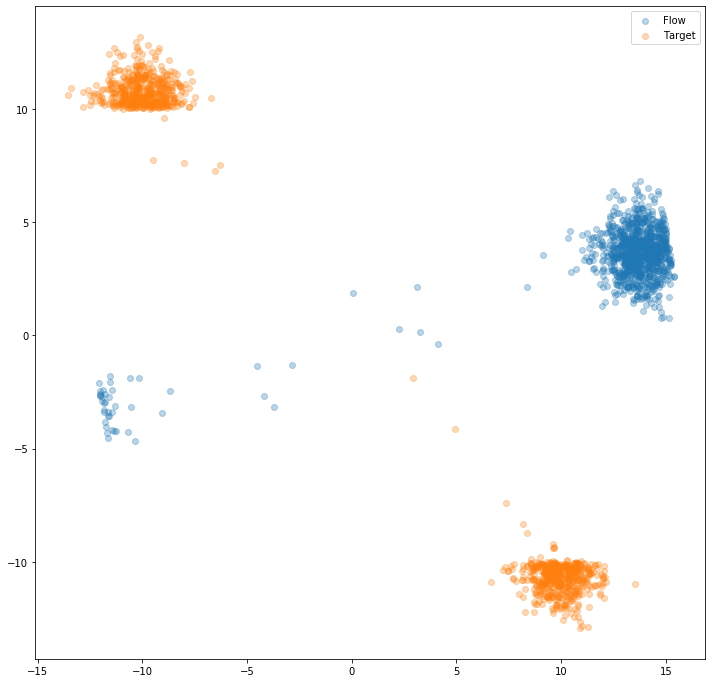

 90%|█████████ | 9/10 [00:02<00:00,  3.62it/s]

[[  69.17446026   13.19777085 3089.98562217  335.24802946 -377.19115636]]
[[14.53386817  3.80433627 19.86085979  1.24635406 14.89979555]]


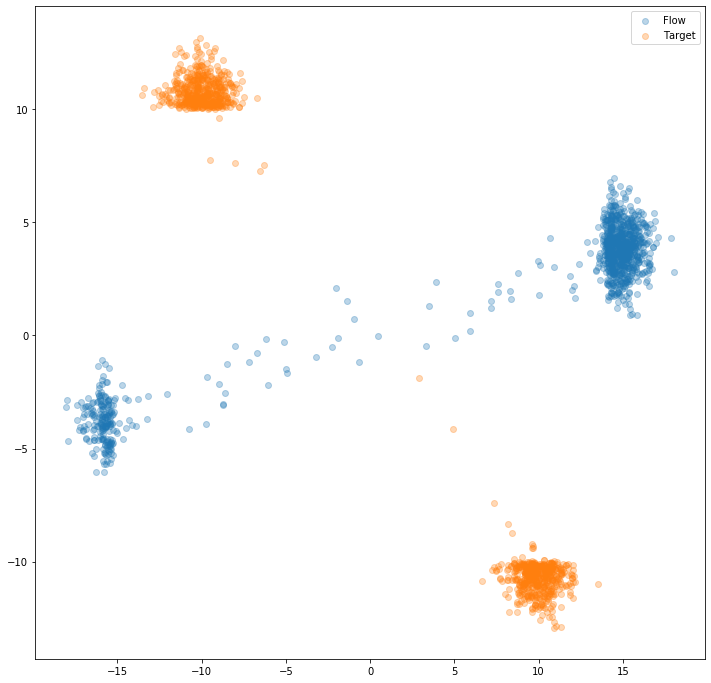

100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

NEW LAMBDA AFTER:
[[14.53386817  3.80433627 19.86085979  1.24635406 14.89979555]]


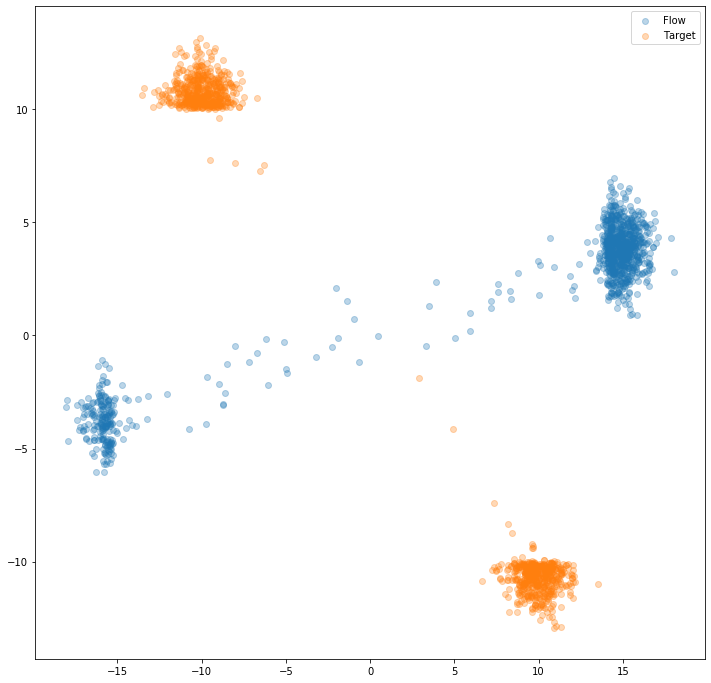

In [10]:
new_lambda = np.copy(lbda)
elbo = []
print("NEW LAMBDA BEFORE:\n{}".format(new_lambda))

# Attempts to find parameters with stochastic gradient descent
for i in tqdm(range(10)):
    grad_f_samples = grad_en_func(new_lambda)
    print(grad_f_samples)
    new_lambda += 0.01*grad_f_samples #+ np.random.randn(*new_lambda.shape)*0.05
    print(new_lambda)
    elbo.append(en_func(grad_f_samples))

    new_flow_func = lambda z: flow(z, new_lambda[0], func)
    updated_flow_samples = new_flow_func(samples)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
    ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
    ax.legend(loc='best')
    plt.show()

print("NEW LAMBDA AFTER:\n{}".format(new_lambda))
grad_f_samples = grad_f_samples[0]

# Compute old samples through new fitted flow
new_flow_func = lambda z: flow(z, new_lambda[0], func)
updated_flow_samples = new_flow_func(samples)
#fig, ax = plt.subplots(ncols=2, figsize=(20,12))
#ax[0].scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
#ax[0].scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
#ax[1].plot(elbo)
#ax[0].legend(loc='best')
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(updated_flow_samples[:,0], updated_flow_samples[:,1], alpha=0.3, label="Flow")
ax.scatter(target_samples[:,0], target_samples[:,1], alpha=0.3, label="Target")
ax.legend(loc='best')
plt.show()

In [11]:
print(new_lambda)

[[14.53386817  3.80433627 19.86085979  1.24635406 14.89979555]]


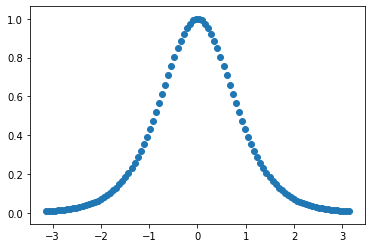

In [12]:
fig, ax = plt.subplots()
xs = np.linspace(-np.pi, np.pi, 100)
grad_f = grad(np.tanh)
plot_vals = []
for x in xs:
    plot_vals.append(grad_f(x))
ax.scatter(xs, plot_vals)